In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from time import time
from datetime import datetime
from src.support_class import *
from src.objComposite import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb
from codeStore import support_fun_resistance as spf_re
# %matplotlib notebook

PWD = os.getcwd()
np.set_printoptions(linewidth=110, precision=5)

params = {'animation.html': 'html5',
          'font.family':    'sans-serif',
          'font.size':      20, }
preamble = r' '
preamble = preamble + '\\usepackage{bm} '
preamble = preamble + '\\usepackage{amsmath} '
preamble = preamble + '\\usepackage{amssymb} '
preamble = preamble + '\\usepackage{mathrsfs} '
preamble = preamble + '\\DeclareMathOperator{\\Tr}{Tr} '
preamble = preamble + '\\newcommand{\\norm}[1]{\\left\\lVert#1\\right\\rVert}'
params['text.latex.preamble'] = preamble
params['text.usetex'] = True
plt.rcParams.update(params)


## single helix

In [2]:
job_dir = 'hlxPart_th0'

tdir = os.path.join(os.getcwd(), job_dir)
problem_kwarg_list, A_list, B1_list, B2_list, C_list = spf_re.load_ABC_list(tdir)
TrA_list = np.array([np.trace(i0) for i0 in A_list])
TrB1_list = np.array([np.trace(i0) for i0 in B1_list])
TrB2_list = np.array([np.trace(i0) for i0 in B2_list])
TrC_list = np.array([np.trace(i0) for i0 in C_list])

A_00_list = np.array([i0[0, 0] for i0 in A_list])
B1_00_list = np.array([i0[0, 0] for i0 in B1_list])
B2_00_list = np.array([i0[0, 0] for i0 in B2_list])
C_00_list = np.array([i0[0, 0] for i0 in C_list])
A_11_list = np.array([i0[1, 1] for i0 in A_list])
B1_11_list = np.array([i0[1, 1] for i0 in B1_list])
B2_11_list = np.array([i0[1, 1] for i0 in B2_list])
C_11_list = np.array([i0[1, 1] for i0 in C_list])
A_22_list = np.array([i0[2, 2] for i0 in A_list])
B1_22_list = np.array([i0[2, 2] for i0 in B1_list])
B2_22_list = np.array([i0[2, 2] for i0 in B2_list])
C_22_list = np.array([i0[2, 2] for i0 in C_list])
A_12_list = np.array([i0[1, 2] for i0 in A_list])

ph_list = np.array([i0['ph'] for i0 in problem_kwarg_list])
ch_list = np.array([i0['ch'] for i0 in problem_kwarg_list])

if 'SLB' in job_dir:
    for t1 in (TrA_list, TrB1_list, TrB2_list, TrC_list, 
               A_00_list, B1_00_list, B2_00_list, C_00_list, 
               A_11_list, B1_11_list, B2_11_list, C_11_list, 
               A_22_list, B1_22_list, B2_22_list, C_22_list, 
               A_12_list):
        t1[(ph_list < 3.5) * (ch_list < 55)] = np.nan

data_hlx = pd.DataFrame({'TrA': TrA_list, 
                         'TrB1': TrB1_list, 
                         'TrB2': TrB2_list, 
                         'TrC': TrC_list, 
                         'A_00': A_00_list, 
                         'B1_00': B1_00_list, 
                         'B2_00': B2_00_list, 
                         'C_00': C_00_list, 
                         'A_11': A_11_list, 
                         'B1_11': B1_11_list, 
                         'B2_11': B2_11_list, 
                         'C_11': C_11_list, 
                         'A_22': A_22_list, 
                         'B1_22': B1_22_list, 
                         'B2_22': B2_22_list, 
                         'C_22': C_22_list, 
                         'A_12': A_12_list, 
                         'ph': ph_list, 
                         'ch': ch_list, 
                         }).pivot_table(index=['ph'], columns=['ch'])


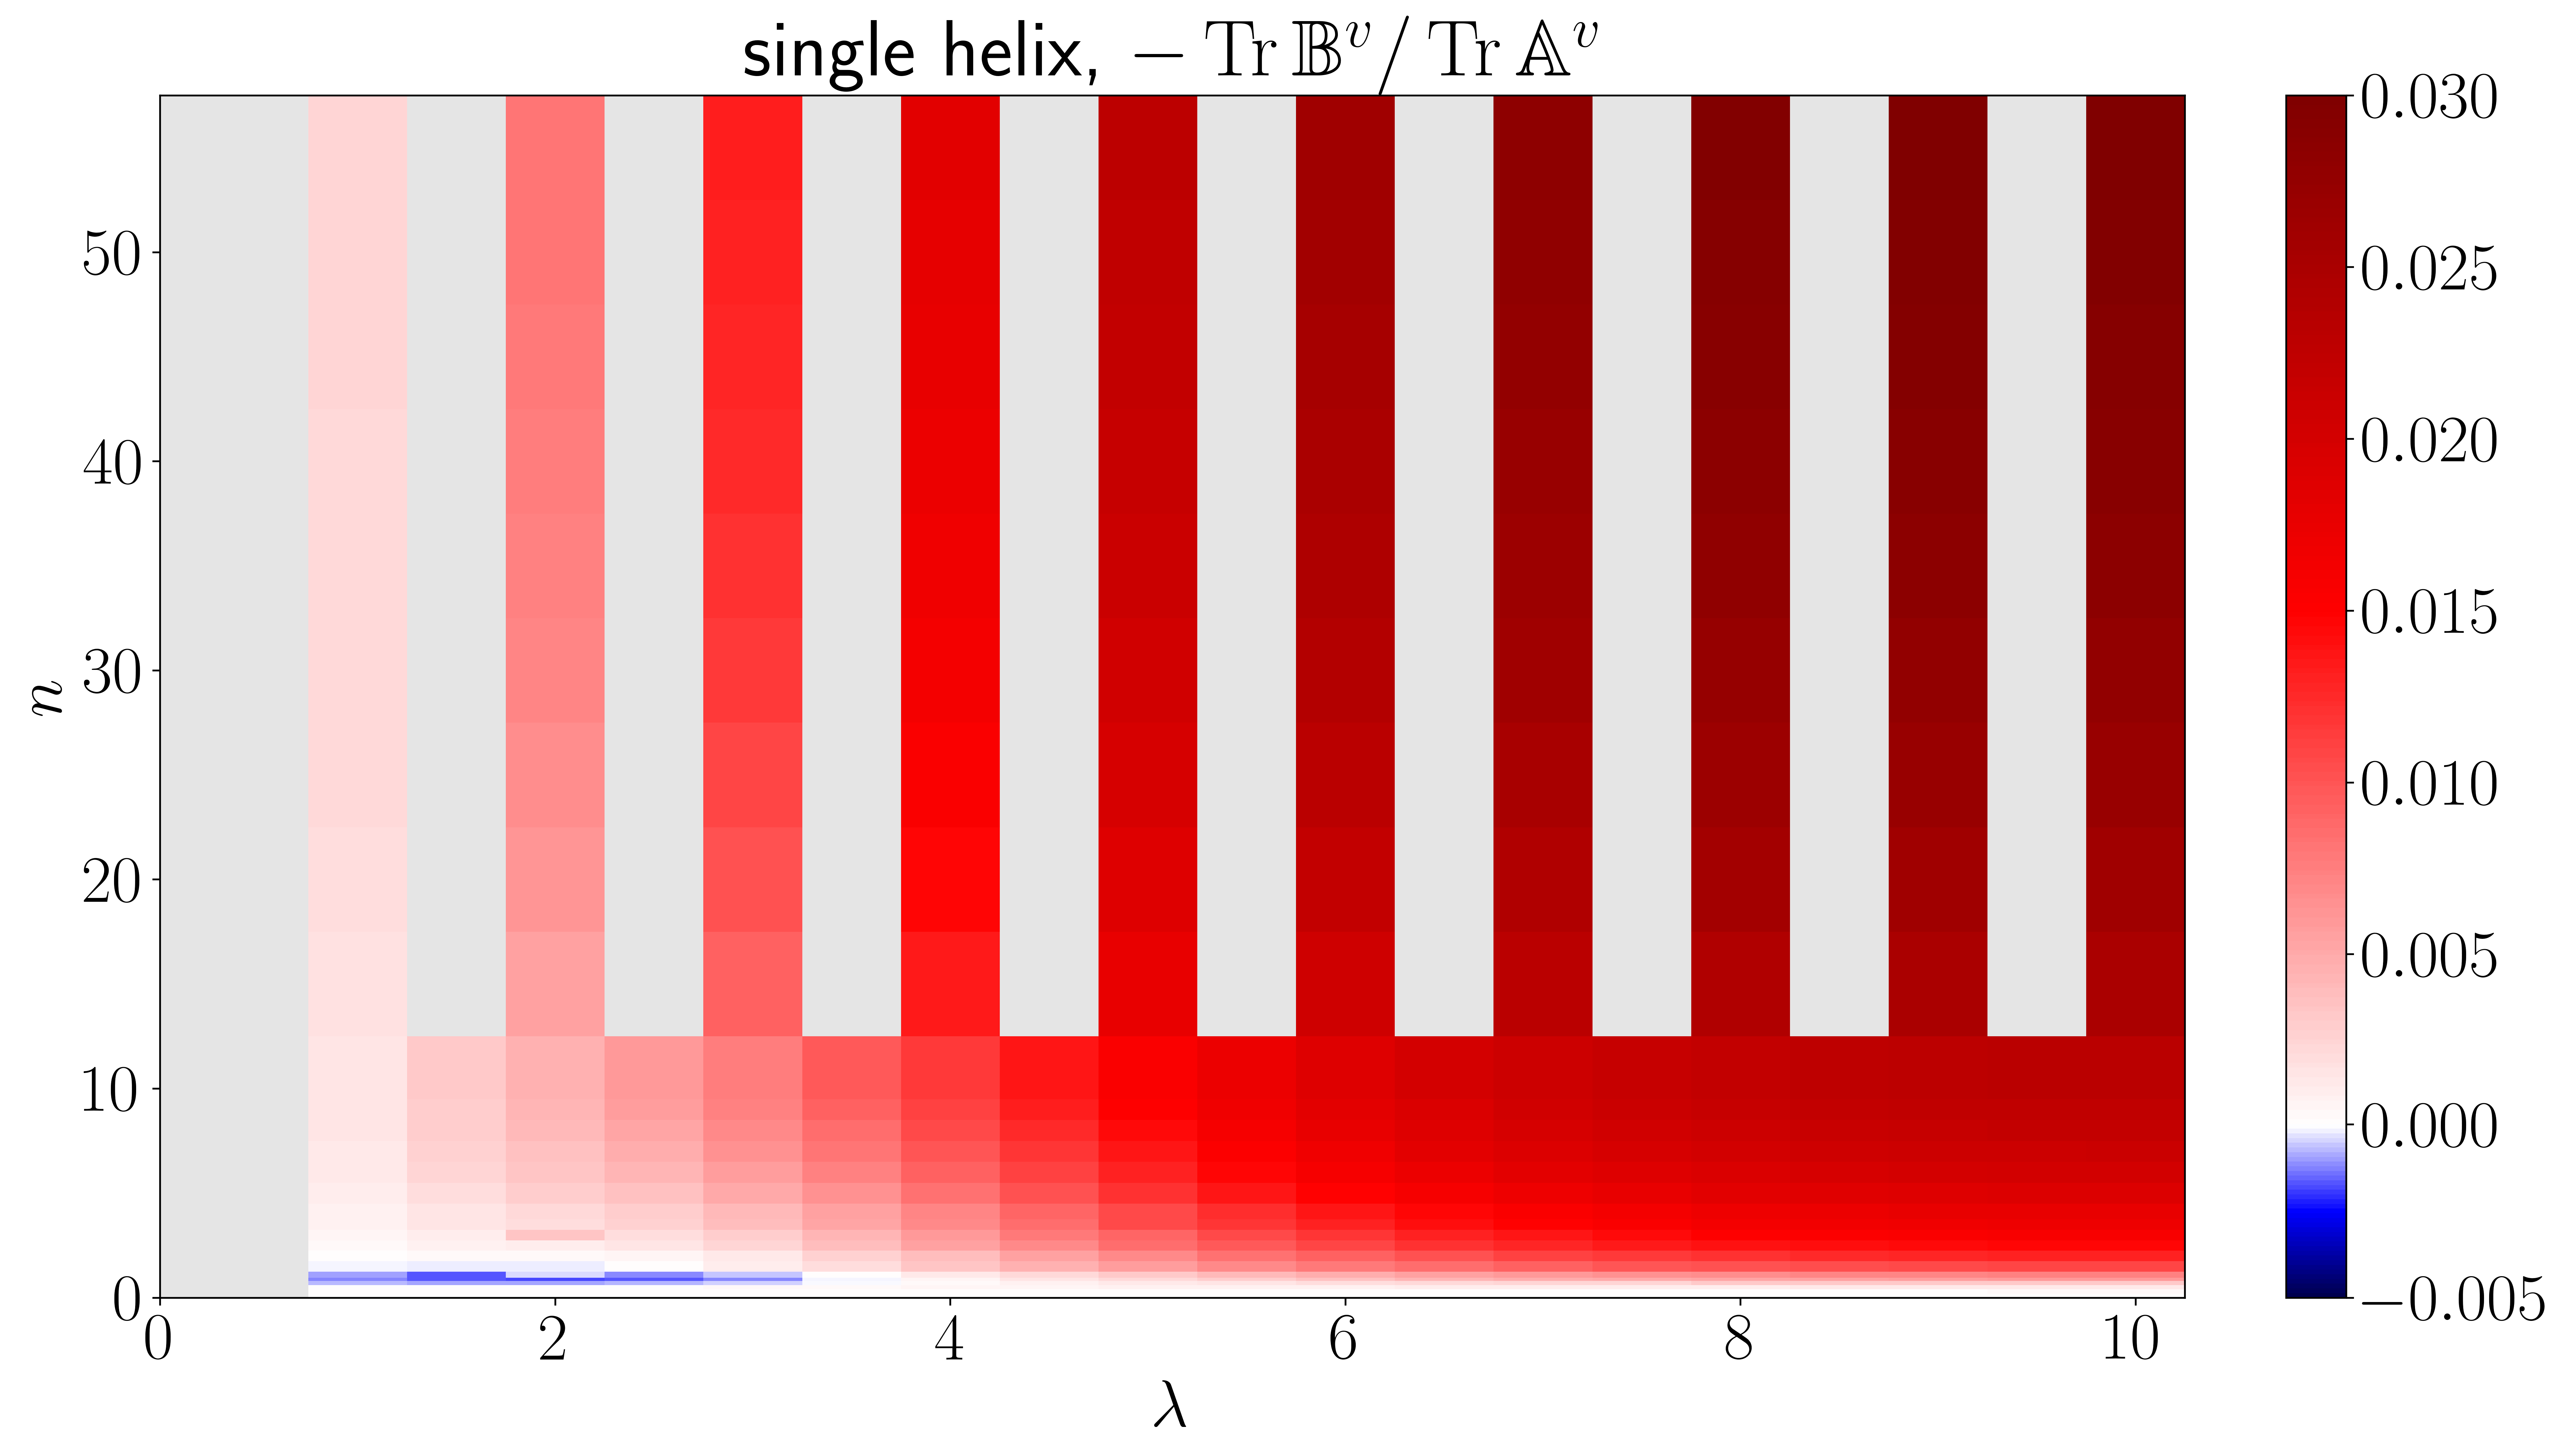

In [15]:
# %matplotlib notebook
%matplotlib inline

plt.rcParams.update({'font.size': 30})
figsize=np.array((16, 9)) * 1
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
#
vmin, vmax, midpoint = -0.005, 0.03, 0
norm = spf.midLinearNorm(midpoint=midpoint, vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('seismic')
fig_name = 'FIG/fig_hlx_TrBTrA_2.pdf'

fig, axs = plt.subplots(1, 1, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')

t1 = -data_hlx.TrB1 / data_hlx.TrA
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
tvalue = t1.values.T
axi = axs
im = axi.pcolormesh(tph, tch, tvalue, cmap=cmap, norm=norm, shading='auto')
# cs = axi.contour(tph, tch, tvalue, [0, ], colors='k')
# axi.clabel(cs, inline=True)
fig.colorbar(im, ax=axi, orientation='vertical')
axi.set_xlabel('$\\lambda$')
axi.set_ylabel('$n$')
axi.set_xlim((0, axi.get_xlim()[1]))
axi.set_ylim((0, axi.get_ylim()[1]))
axi.patch.set_facecolor('grey')
axi.patch.set_alpha(0.2)
axi.set_title('single helix, $-\\Tr \\mathbb{B}^v / \\Tr \\mathbb{A}^v$')

fig.savefig(fig_name)

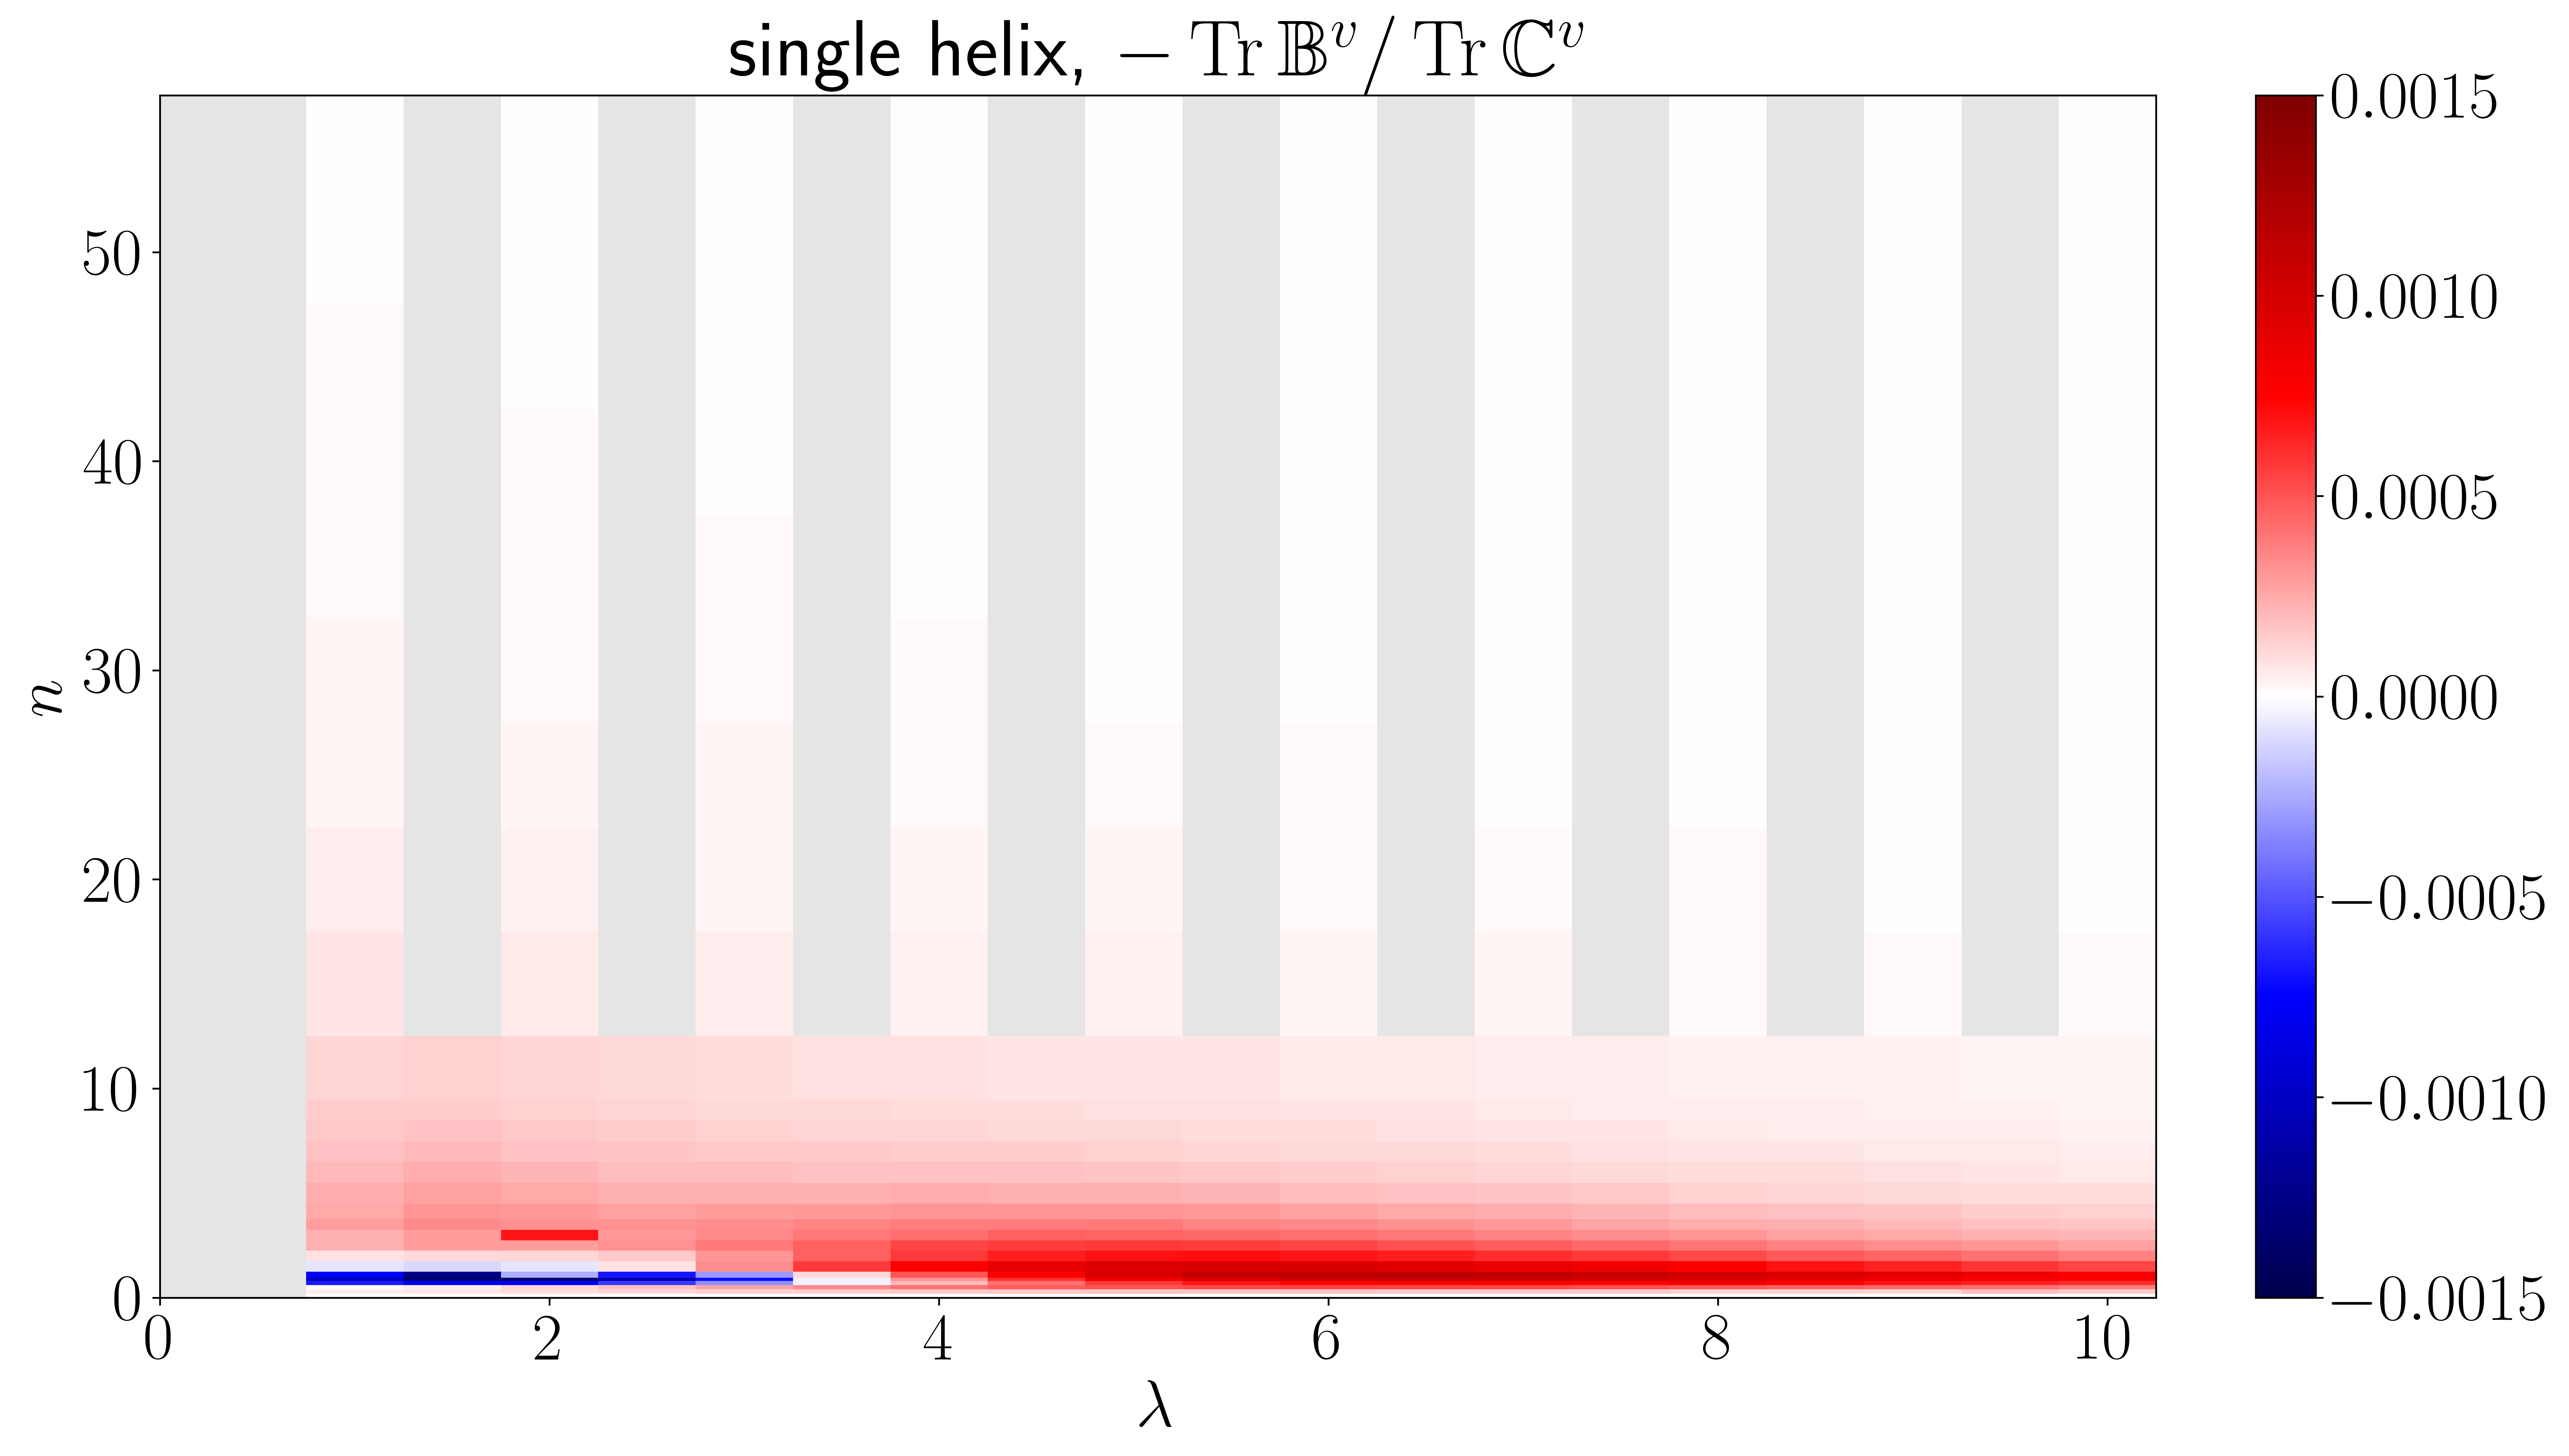

In [14]:
# %matplotlib notebook
%matplotlib inline

plt.rcParams.update({'font.size': 30})
figsize=np.array((16, 9)) * 1
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
#
vmin, vmax, midpoint = -0.0015, 0.0015, 0
norm = spf.midLinearNorm(midpoint=midpoint, vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('seismic')
fig_name = 'FIG/fig_hlx_TrBTrC_2.pdf'

fig, axs = plt.subplots(1, 1, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')

t1 = -data_hlx.TrB1 / data_hlx.TrC
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
tvalue = t1.values.T
axi = axs
im = axi.pcolormesh(tph, tch, tvalue, cmap=cmap, norm=norm, shading='auto')
# cs = axi.contour(tph, tch, tvalue, [0, ], colors='k')
# axi.clabel(cs, inline=True)
fig.colorbar(im, ax=axi, orientation='vertical')
axi.set_xlabel('$\\lambda$')
axi.set_ylabel('$n$')
axi.set_xlim((0, axi.get_xlim()[1]))
axi.set_ylim((0, axi.get_ylim()[1]))
axi.patch.set_facecolor('grey')
axi.patch.set_alpha(0.2)
axi.set_title('single helix, $-\\Tr \\mathbb{B}^v / \\Tr \\mathbb{C}^v$')

fig.savefig(fig_name)

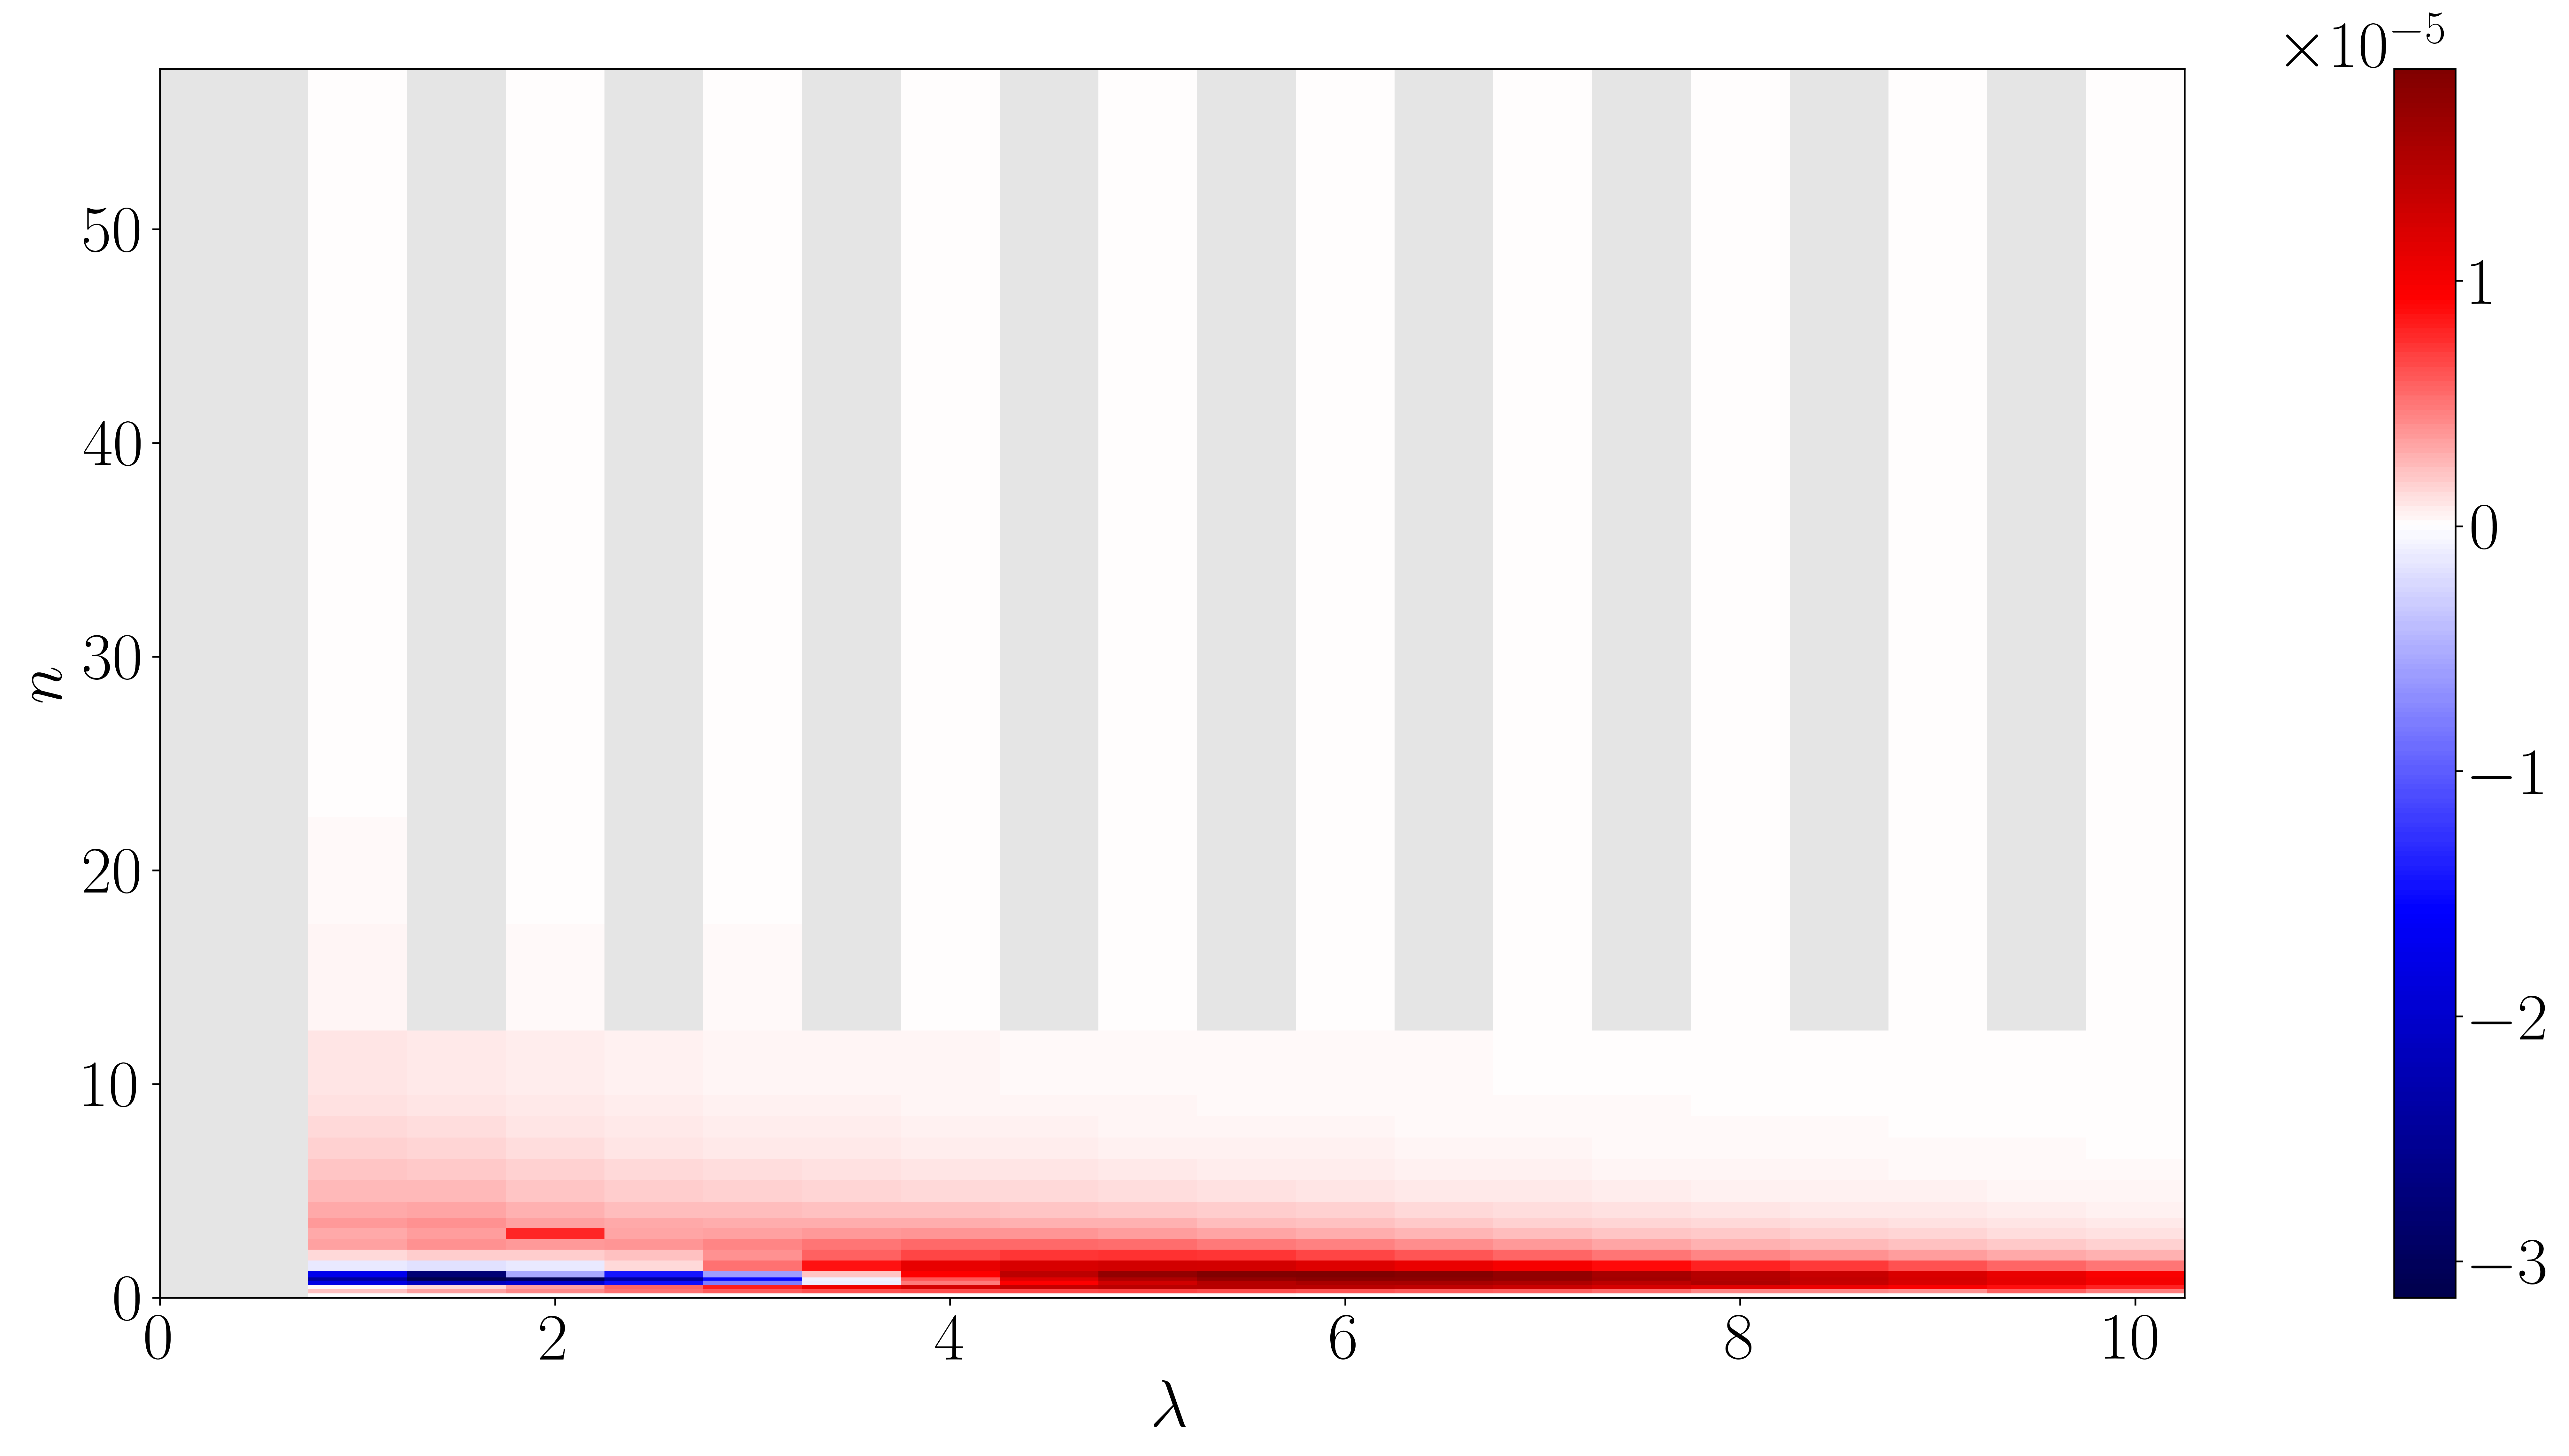

In [11]:
# %matplotlib notebook
%matplotlib inline

plt.rcParams.update({'font.size': 30})
figsize=np.array((16, 9)) * 1
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
#
vmin, vmax, midpoint = None, None, 0
norm = spf.midLinearNorm(midpoint=midpoint, vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('seismic')
# fig_name = 'FIG/fig_hlx_TrBTrC_2.pdf'

fig, axs = plt.subplots(1, 1, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')

t1 = -data_hlx.TrB1 / (data_hlx.TrA * data_hlx.TrC)
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
tvalue = t1.values.T
axi = axs
im = axi.pcolormesh(tph, tch, tvalue, cmap=cmap, norm=norm, shading='auto')
# cs = axi.contour(tph, tch, tvalue, [0, ], colors='k')
# axi.clabel(cs, inline=True)
fig.colorbar(im, ax=axi, orientation='vertical')
axi.set_xlabel('$\\lambda$')
axi.set_ylabel('$n$')
axi.set_xlim((0, axi.get_xlim()[1]))
axi.set_ylim((0, axi.get_ylim()[1]))
axi.patch.set_facecolor('grey')
axi.patch.set_alpha(0.2)
# axi.set_title('single helix, $-\\Tr \\mathbb{B}^v / \\Tr \\mathbb{C}^v$')

# fig.savefig(fig_name)

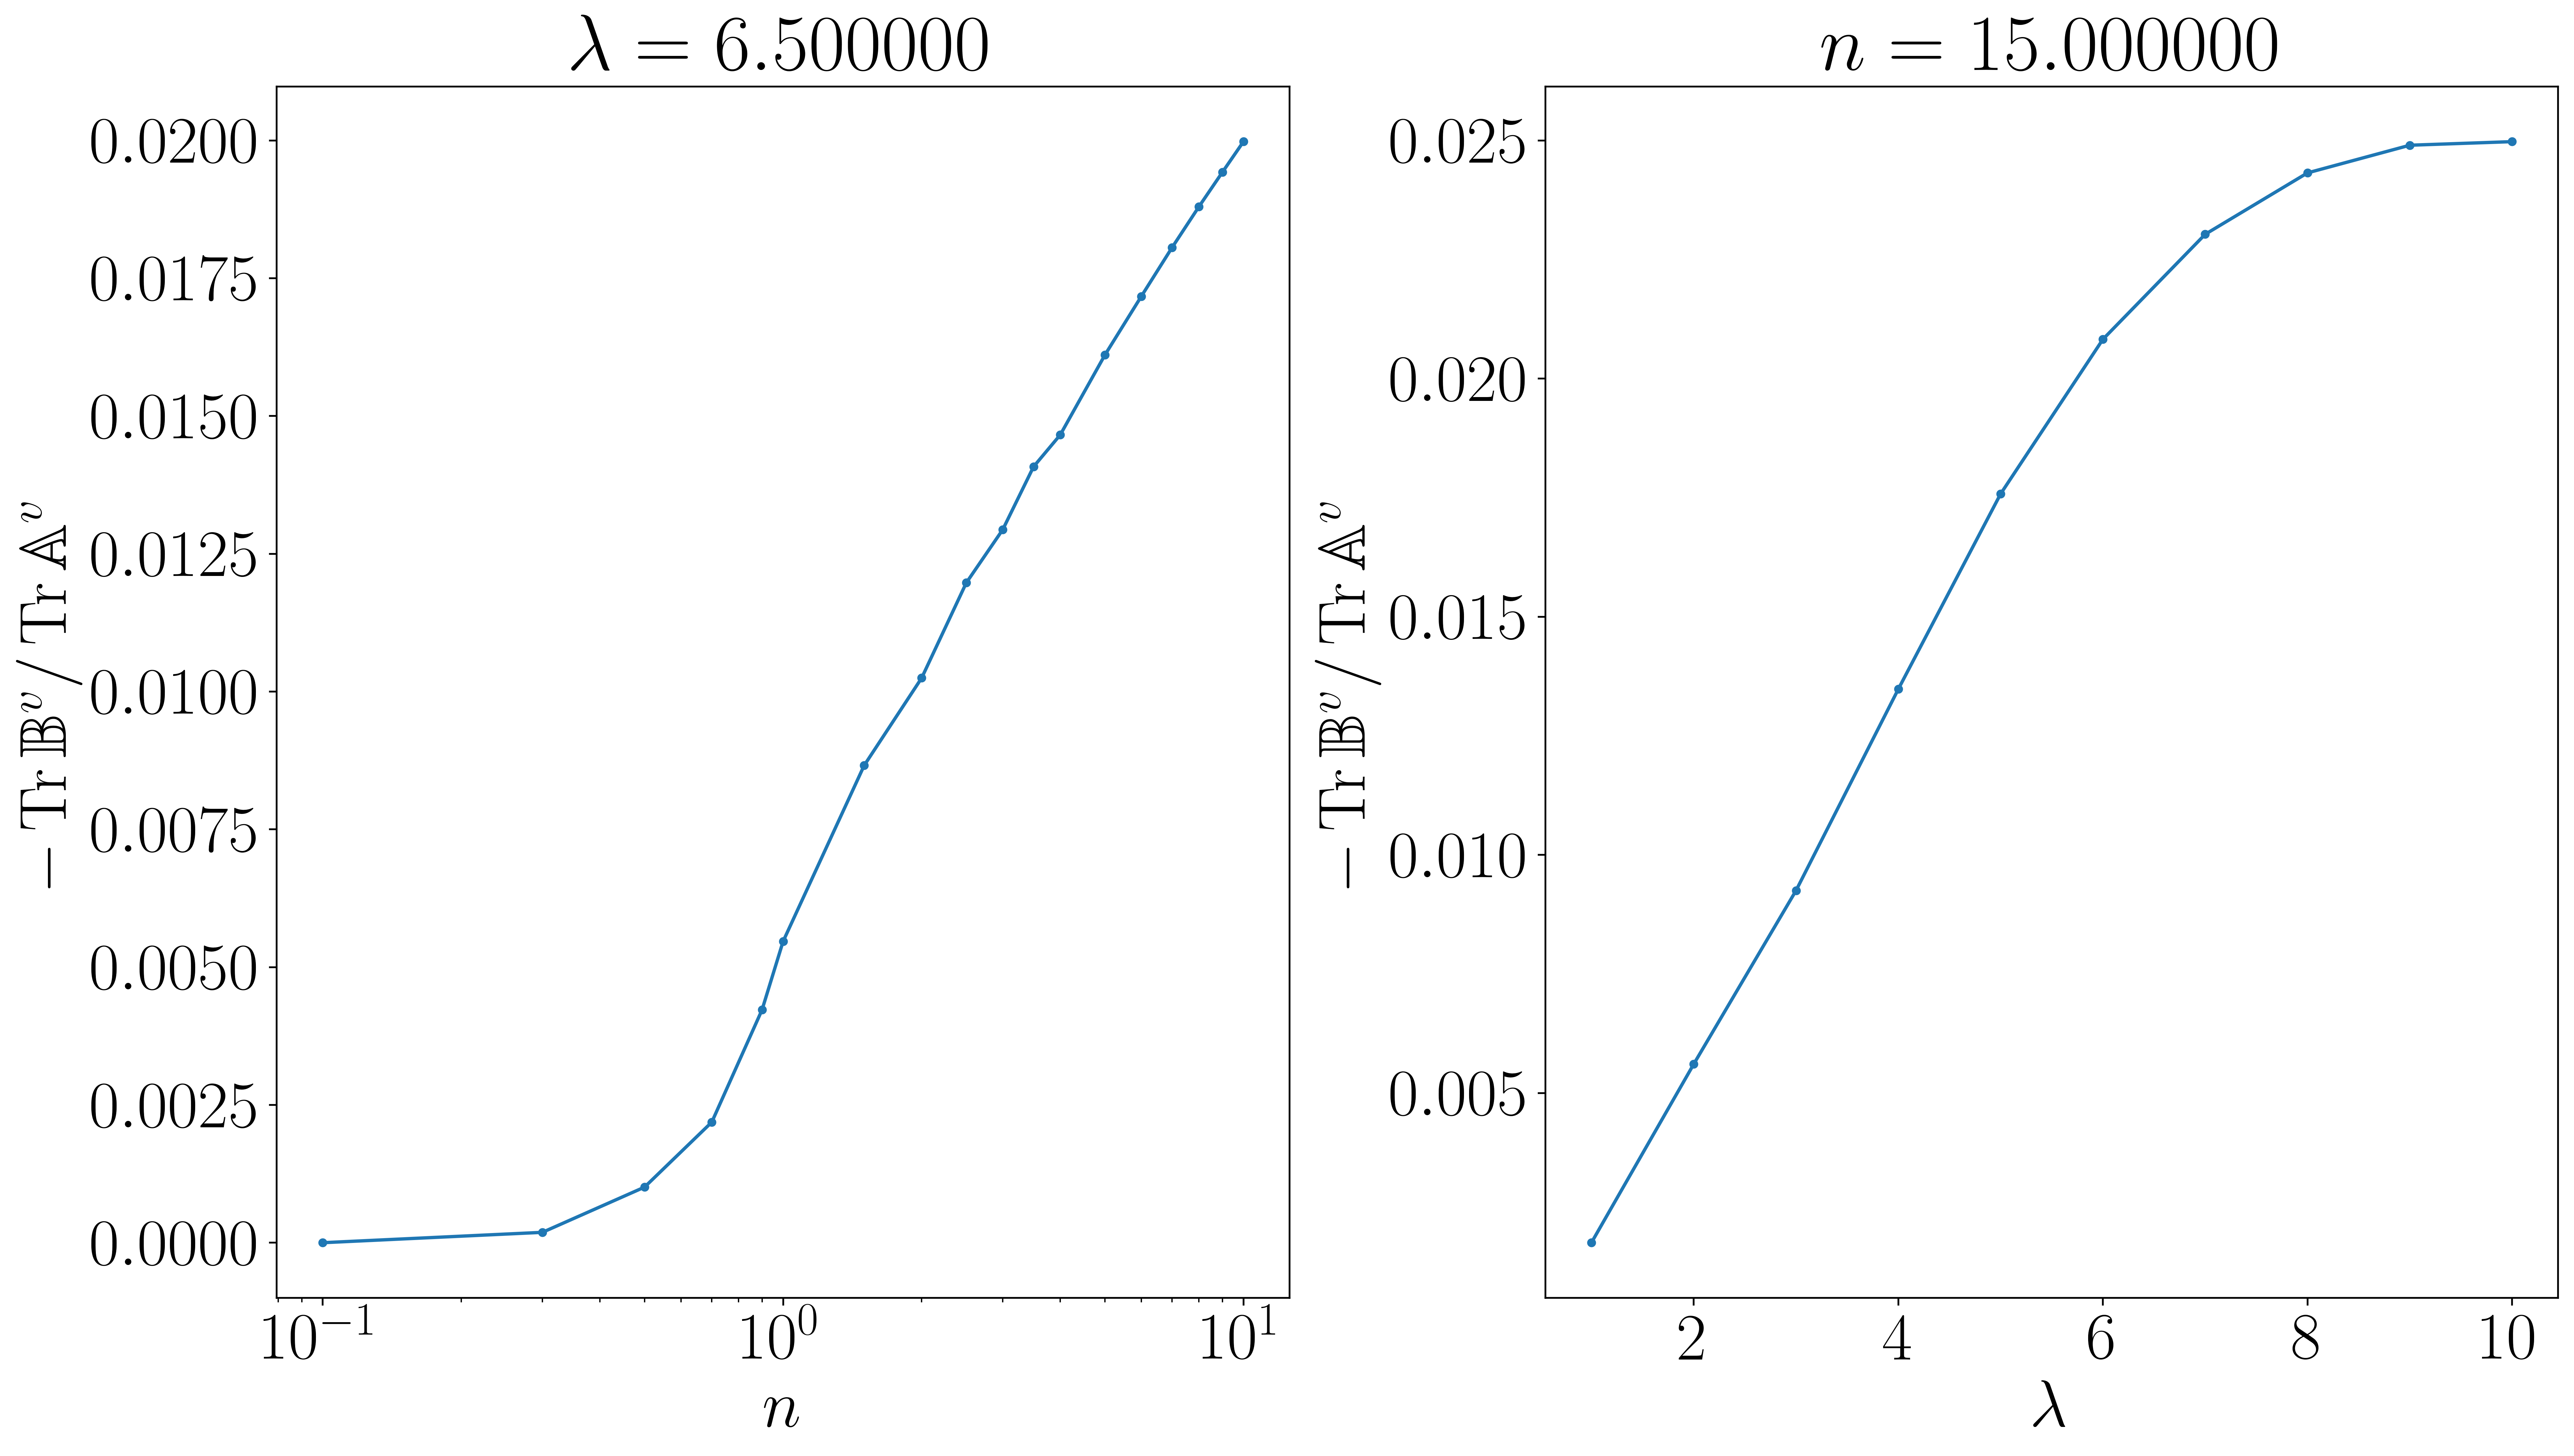

In [8]:
# %matplotlib notebook
%matplotlib inline

plt.rcParams.update({'font.size': 30})
figsize=np.array((16, 9)) * 1
dpi = 500 if 'inline' in matplotlib.get_backend() else 100

t1 = -data_hlx.TrB1 / data_hlx.TrA
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
#
ttph = tph[-8]
ttch = tch[18]
fig_name = 'FIG/fig_hlx_settling_lmd6.5.pdf'

fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')
#
axi = axs[0]
tt1 = t1.loc[ttph]
ttvalue = tt1.values
tidx = np.isfinite(ttvalue)
axi.plot(tch[tidx], ttvalue[tidx], '.-')
axi.set_title('$\\lambda = %f$' % ttph)
axi.set_xlabel('$n$')
axi.set_ylabel('$-\\Tr \\mathbb{B}^v / \\Tr \\mathbb{A}^v$')
axi.set_xscale('log')
#
axi = axs[1]
tt1 = t1[ttch]
ttvalue = tt1.values
tidx = np.isfinite(ttvalue)
axi.plot(tph[tidx], ttvalue[tidx], '.-')
axi.set_title('$n = %f$' % ttch)
axi.set_xlabel('$\\lambda$')
axi.set_ylabel('$-\\Tr \\mathbb{B}^v / \\Tr \\mathbb{A}^v$')

fig.savefig(fig_name)

Text(0.5, 0.98, '$\\mathbb{A}^v / n$, $\\lambda = 6.500000$')

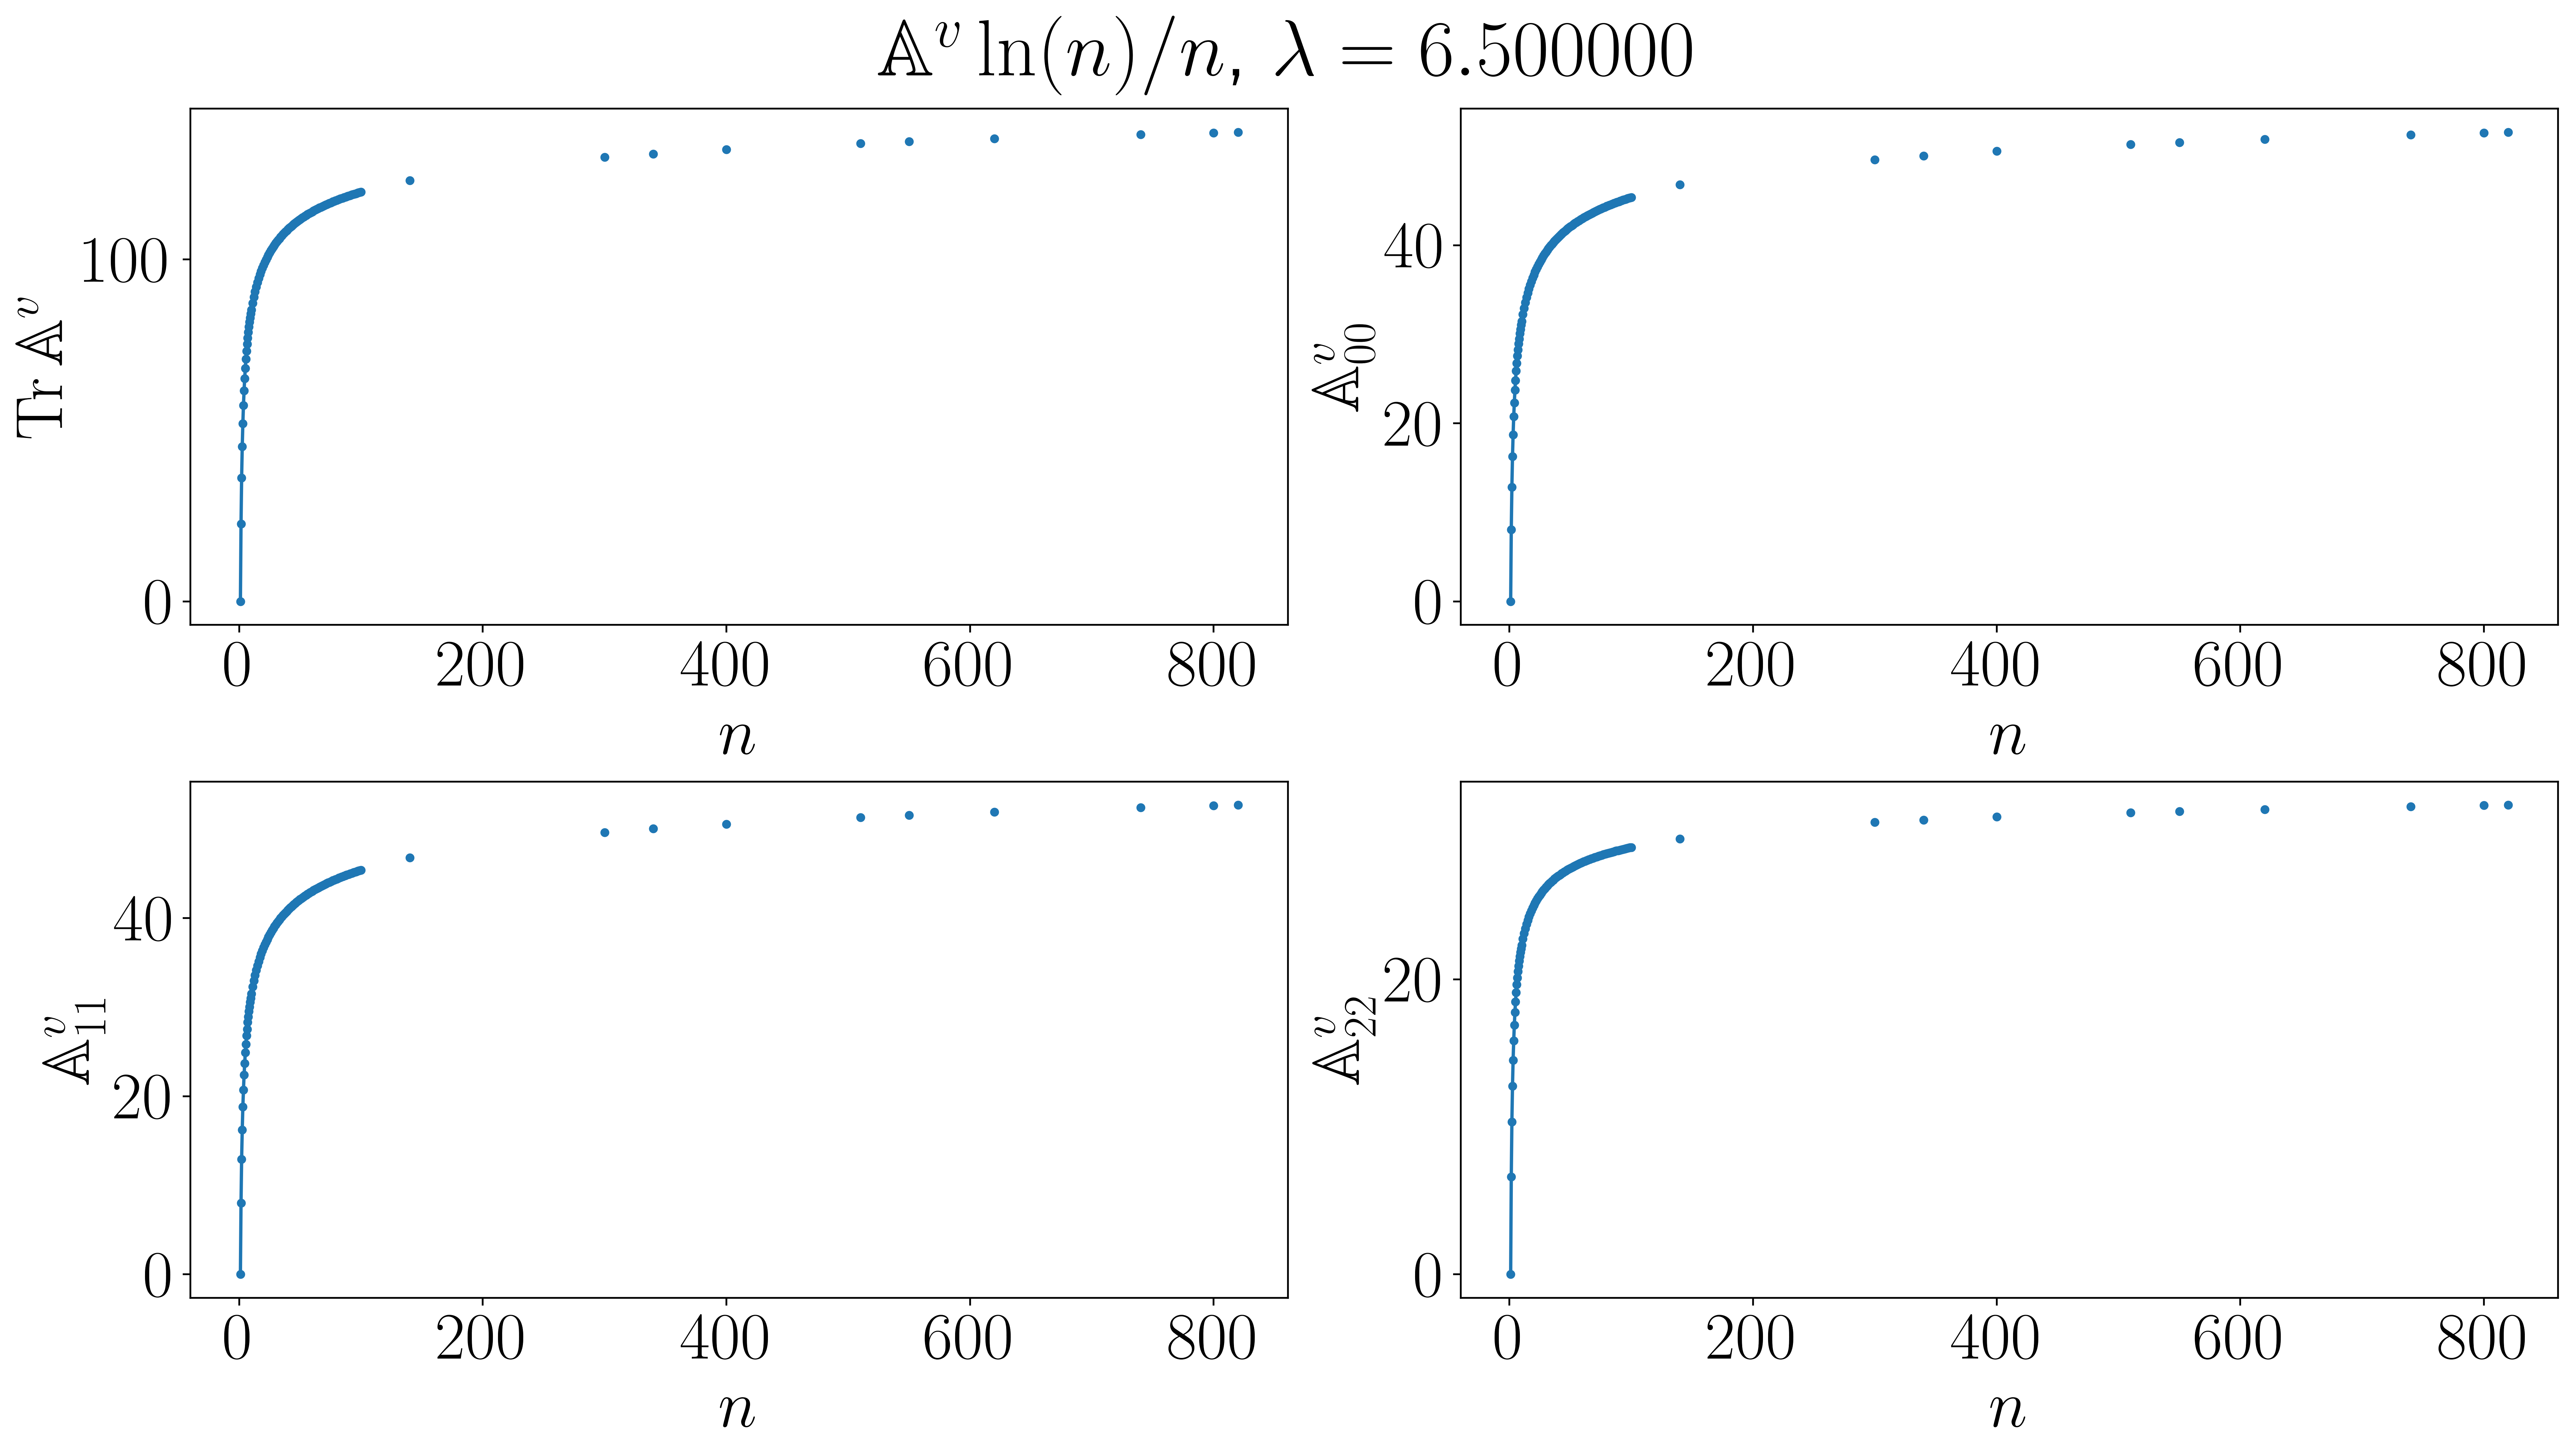

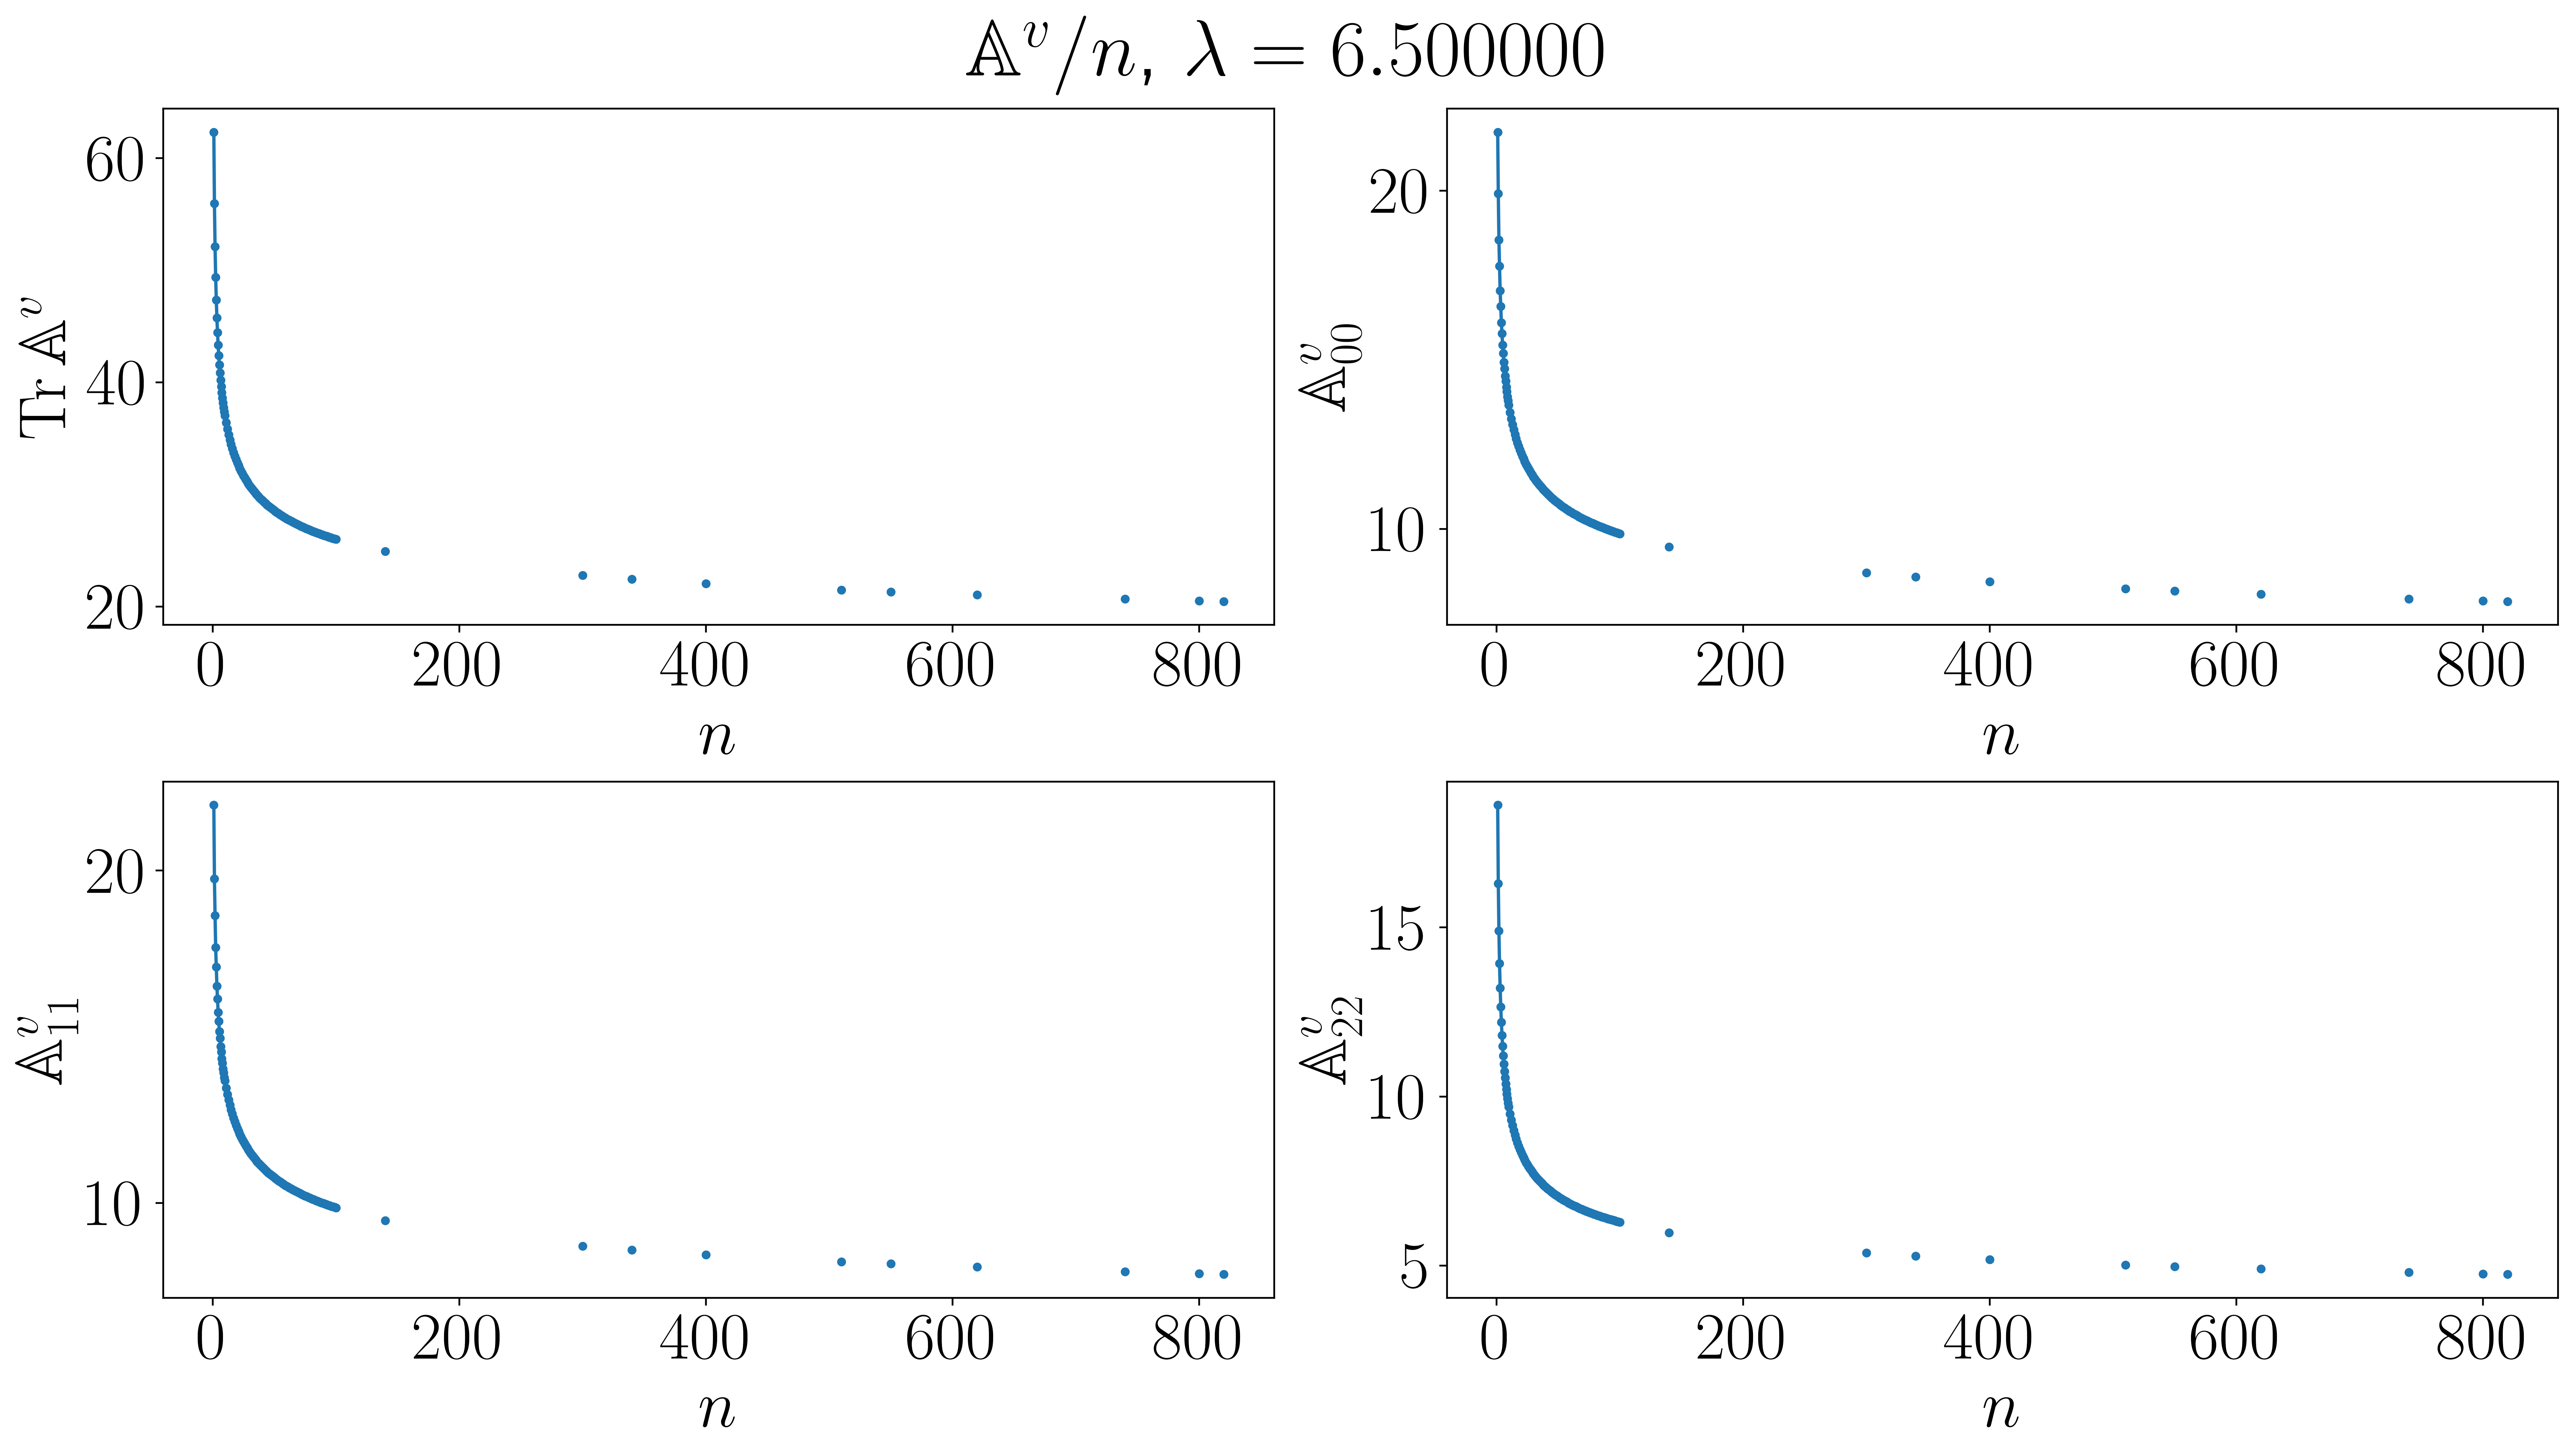

In [5]:
# %matplotlib notebook
%matplotlib inline
def tget_data(t1, ttph):
#     t1 = data_hlx.TrB1
#     ttph = 6.5
    tph = t1.index.values  # ph
    tch = t1.columns.values  # ch
    tt1 = t1.loc[ttph]
    ttvalue = tt1.values
    return tch, ttvalue
    
plt.rcParams.update({'font.size': 30})
figsize=np.array((16, 9)) * 1
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
ttph = 6.5
# ttph = data_hlx.TrA.index.values[-1]

fig, axs = plt.subplots(2, 2, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')
axs = axs.ravel()
#
axi = axs[0]
tch, ttvalue = tget_data(data_hlx.TrA, ttph)
axi.plot(tch, ttvalue * np.log(tch) / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\Tr \\mathbb{A}^v$')
# axi.set_xscale('log')
#
axi = axs[1]
tch, ttvalue = tget_data(data_hlx.A_00, ttph)
axi.plot(tch, ttvalue * np.log(tch) / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{A}^v_{00}$')
# axi.set_xscale('log')
# 
axi = axs[2]
tch, ttvalue = tget_data(data_hlx.A_11, ttph)
axi.plot(tch, ttvalue * np.log(tch) / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{A}^v_{11}$')
# axi.set_xscale('log')
#
axi = axs[3]
tch, ttvalue = tget_data(data_hlx.A_22, ttph)
axi.plot(tch, ttvalue * np.log(tch) / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{A}^v_{22}$')
# axi.set_xscale('log')
fig.suptitle('$\\mathbb{A}^v \\ln(n) / n$, $\\lambda = %f$' % ttph)

#--------------------------------------------------------------------------#
fig, axs = plt.subplots(2, 2, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')
axs = axs.ravel()
#
axi = axs[0]
tch, ttvalue = tget_data(data_hlx.TrA, ttph)
axi.plot(tch, ttvalue / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\Tr \\mathbb{A}^v$')
# axi.set_xscale('log')
#
axi = axs[1]
tch, ttvalue = tget_data(data_hlx.A_00, ttph)
axi.plot(tch, ttvalue / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{A}^v_{00}$')
# axi.set_xscale('log')
# 
axi = axs[2]
tch, ttvalue = tget_data(data_hlx.A_11, ttph)
axi.plot(tch, ttvalue / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{A}^v_{11}$')
# axi.set_xscale('log')
#
axi = axs[3]
tch, ttvalue = tget_data(data_hlx.A_22, ttph)
axi.plot(tch, ttvalue / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{A}^v_{22}$')
# axi.set_xscale('log')
fig.suptitle('$\\mathbb{A}^v / n$, $\\lambda = %f$' % ttph)


Text(0.5, 0.98, '$\\norm{(\\mathbb{B}^{v1} - \\mathbb{B}^{v2}) / (\\mathbb{B}^{v1} + \\mathbb{B}^{v2})}$, $\\lambda = 6.500000$')

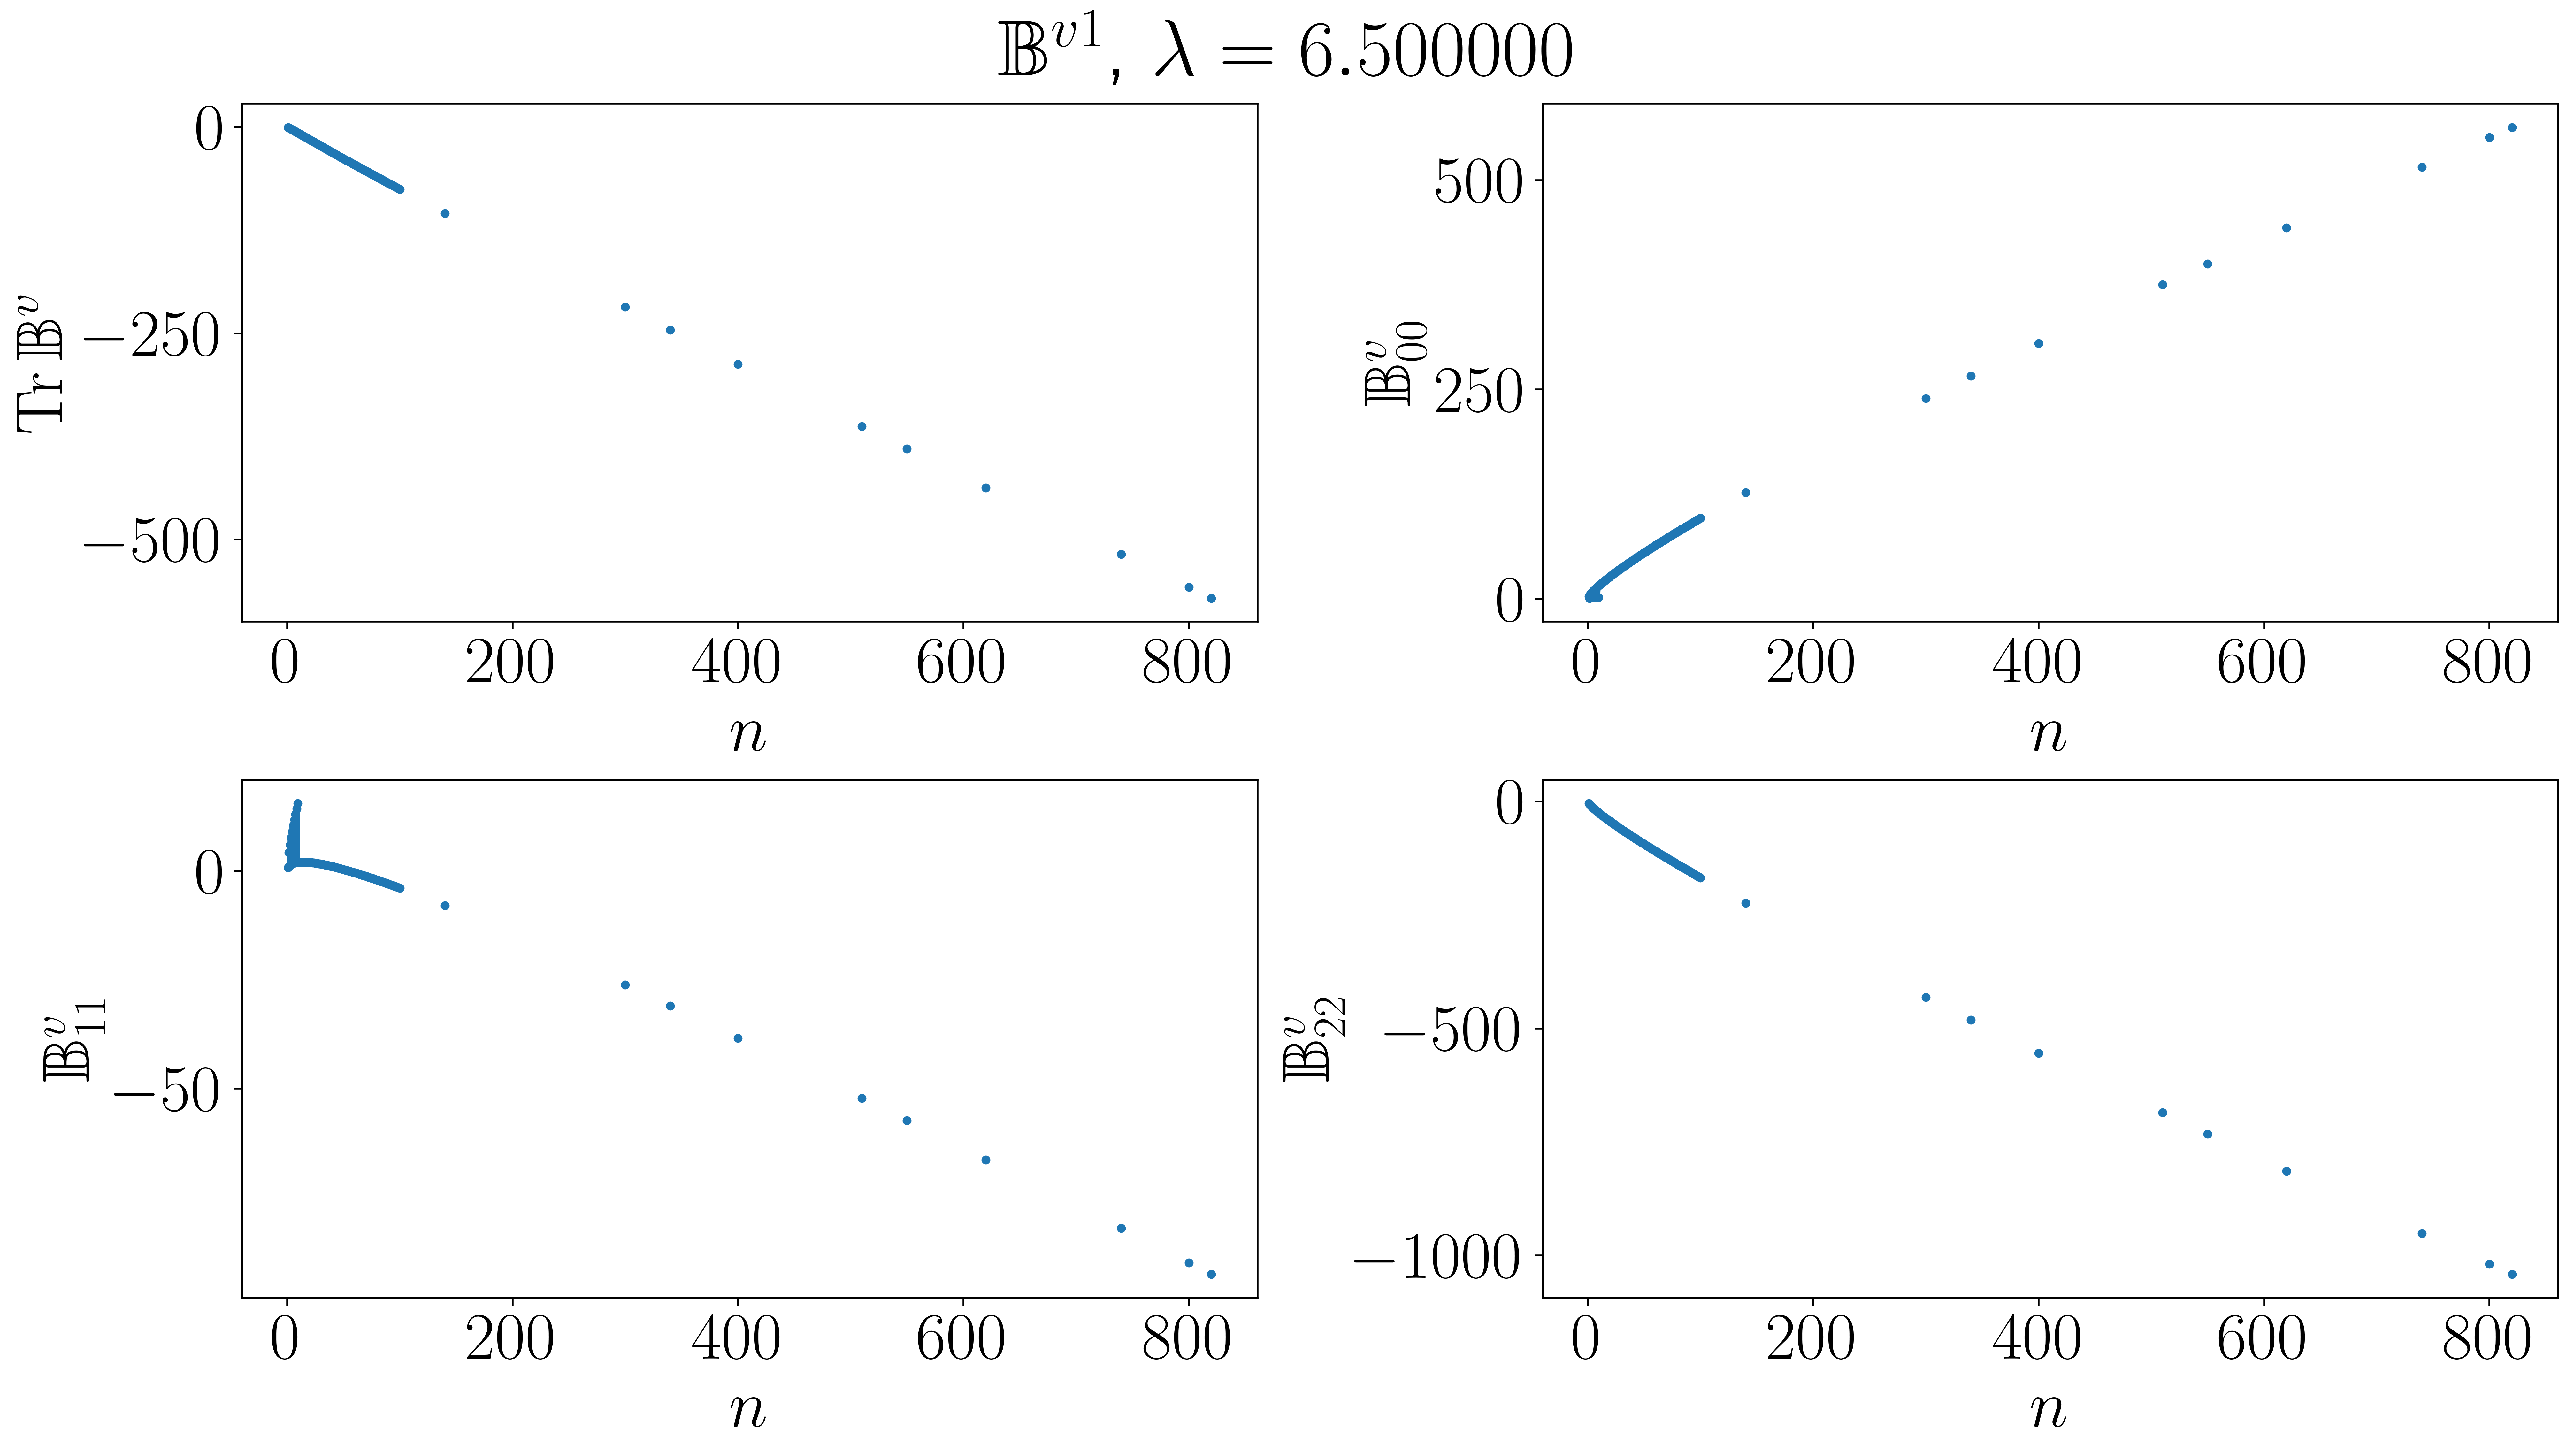

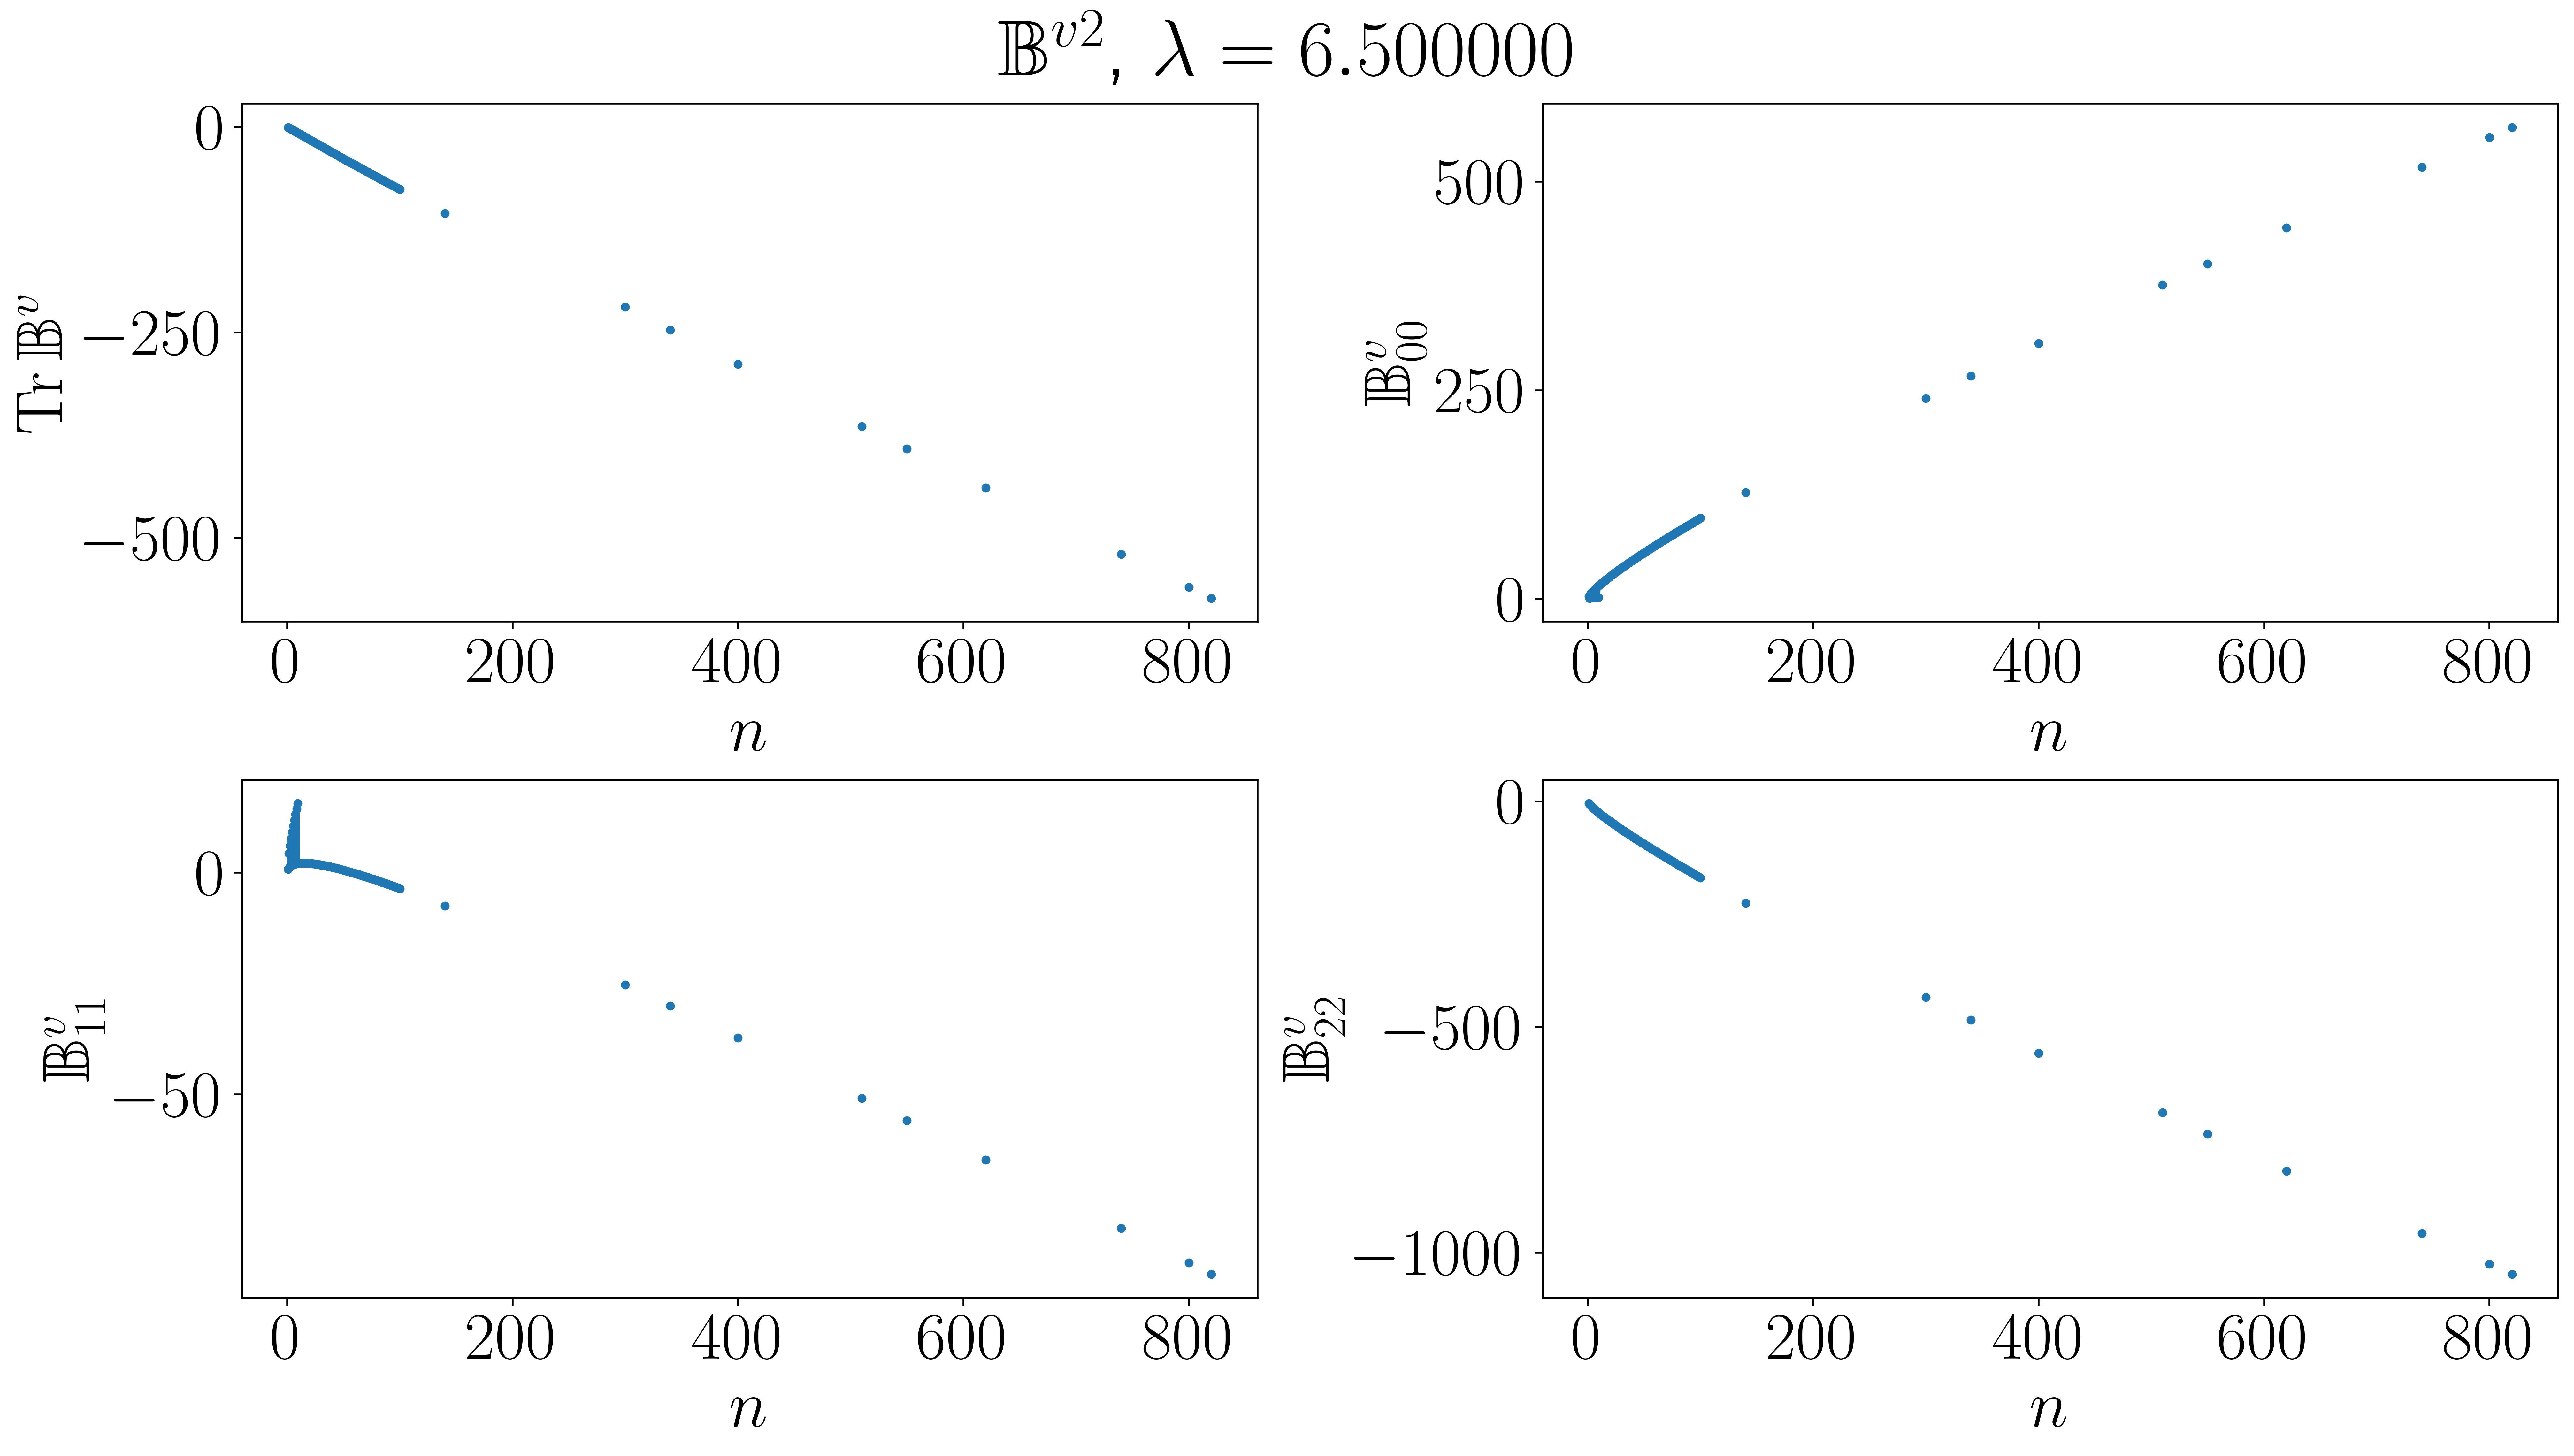

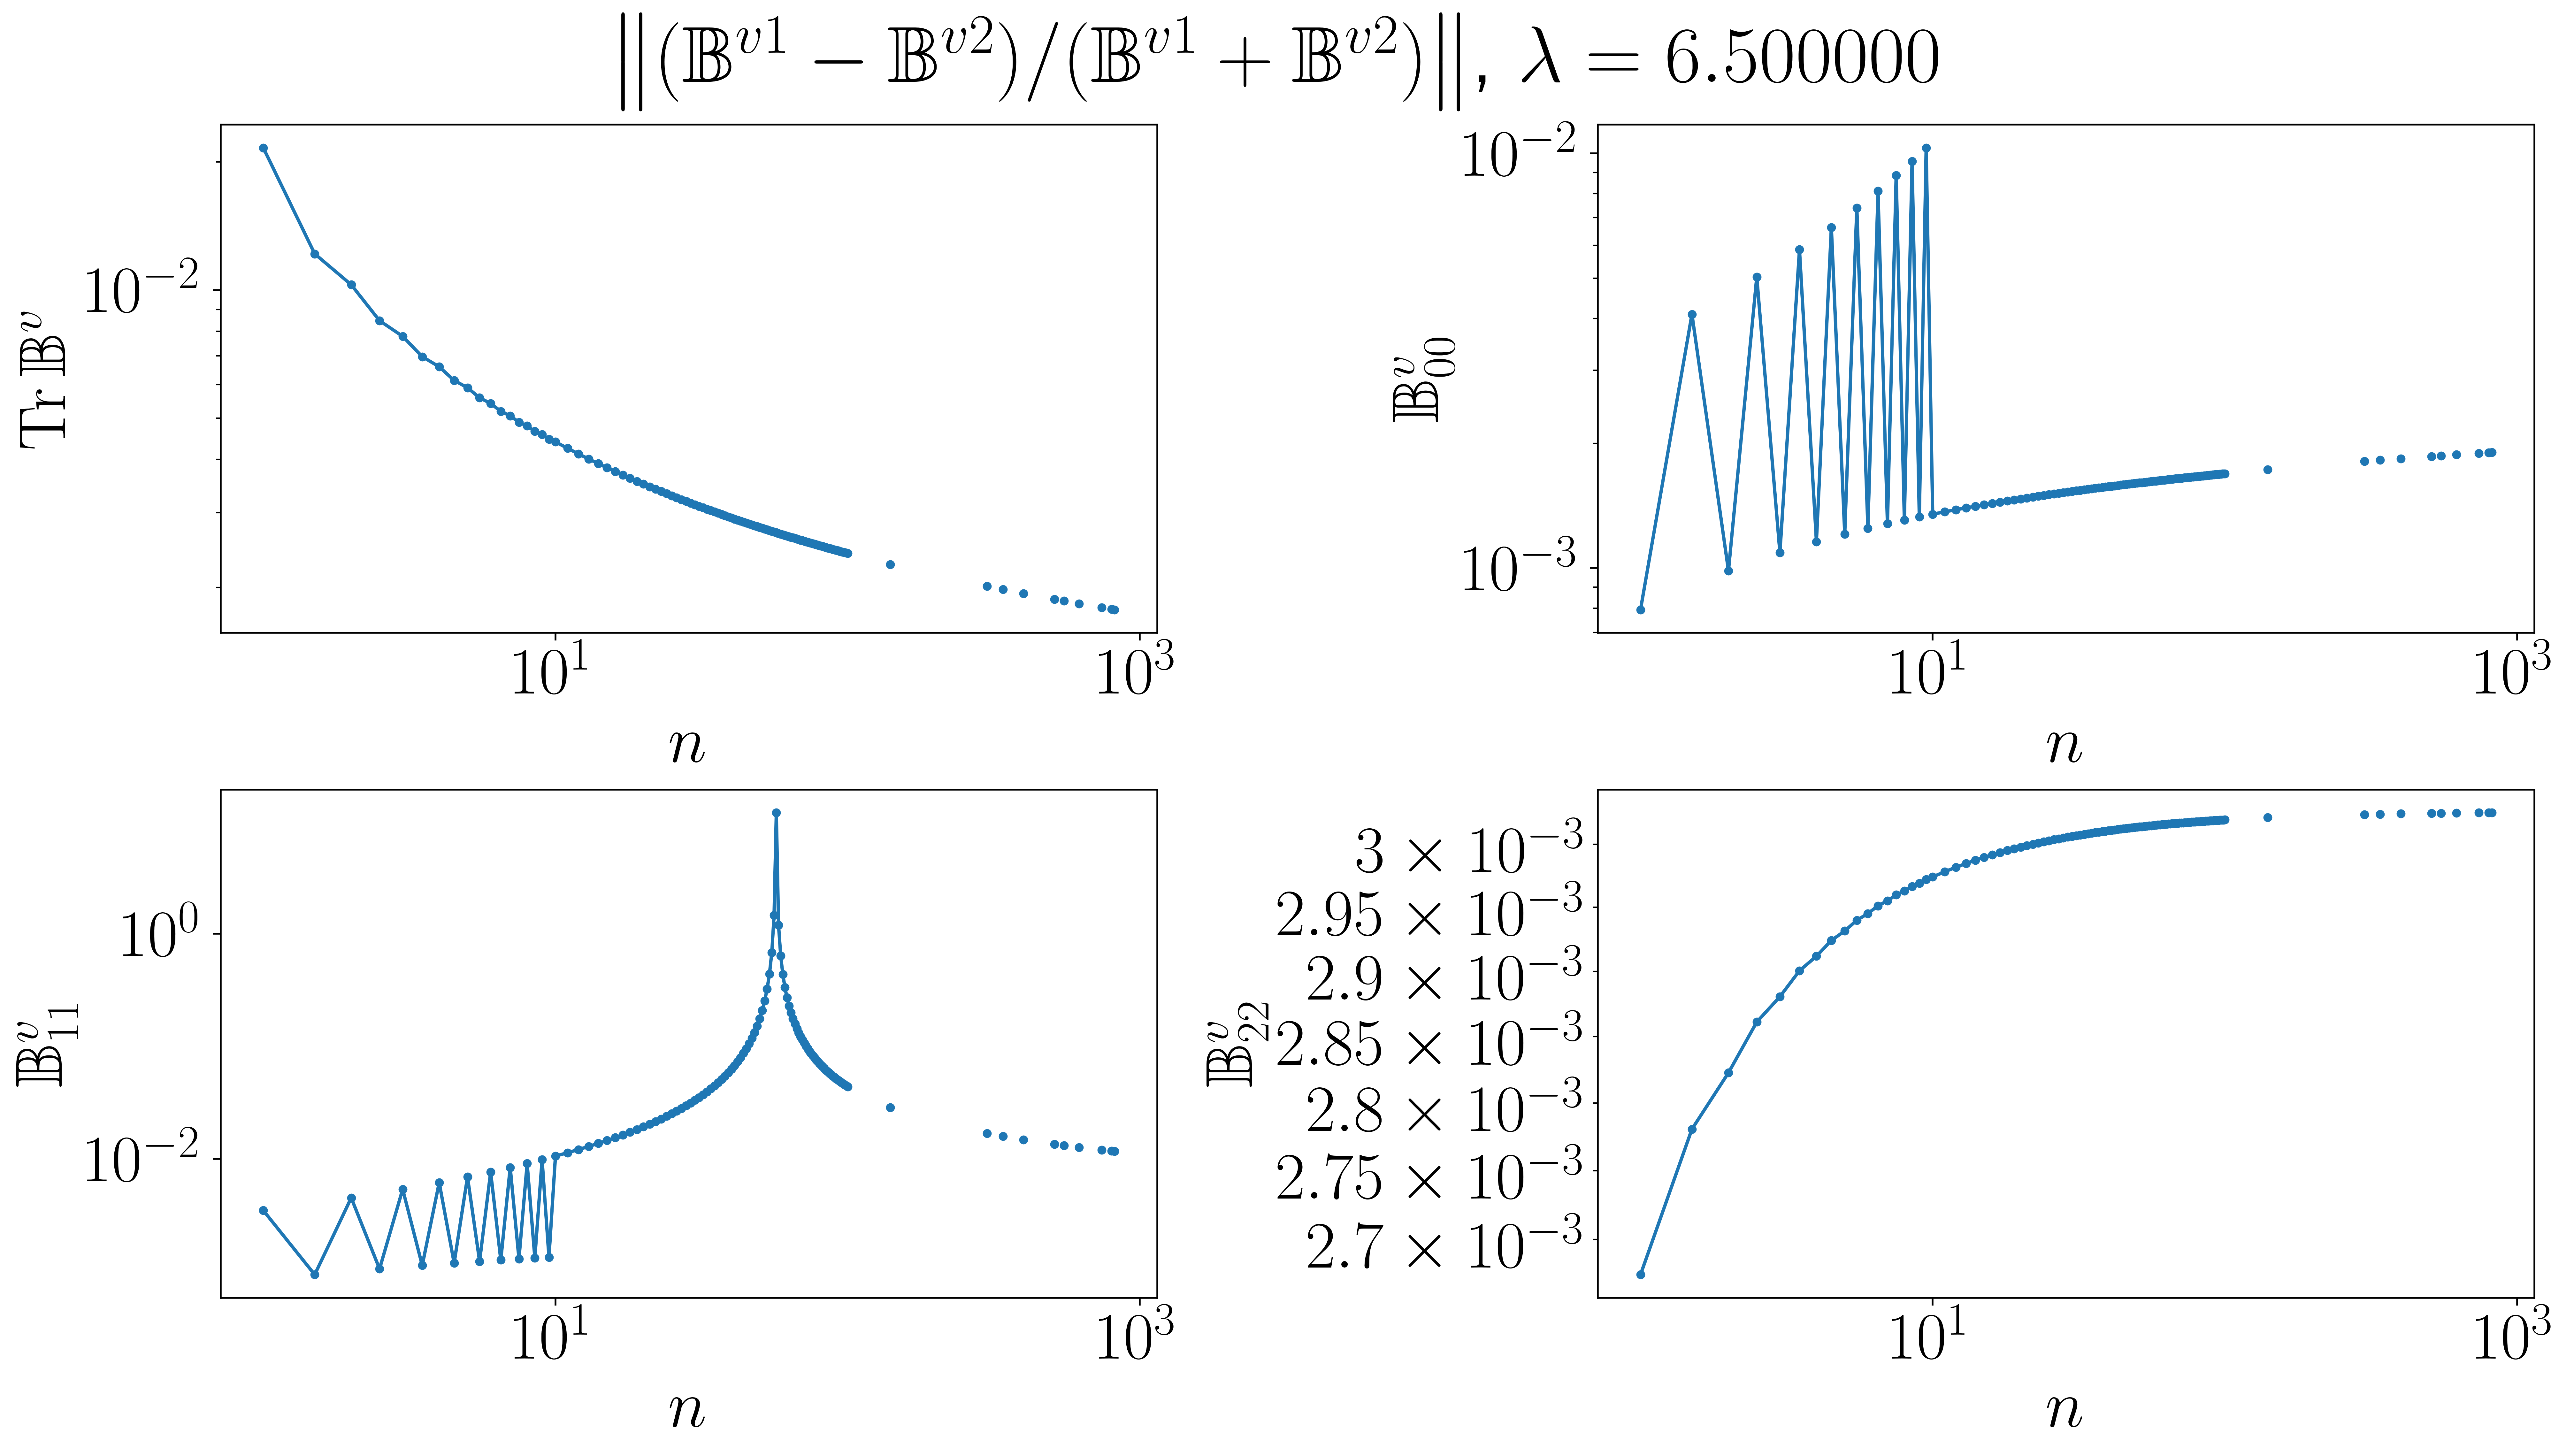

In [9]:
# %matplotlib notebook
%matplotlib inline
def tget_data(t1, ttph):
#     t1 = data_hlx.TrB1
#     ttph = 6.5
    tph = t1.index.values  # ph
    tch = t1.columns.values  # ch
    tt1 = t1.loc[ttph]
    ttvalue = tt1.values
    return tch, ttvalue
    
plt.rcParams.update({'font.size': 30})
figsize=np.array((16, 9)) * 1
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
ttph = 6.5

fig, axs = plt.subplots(2, 2, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')
axs = axs.ravel()
#
axi = axs[0]
tch, ttvalue = tget_data(data_hlx.TrB1, ttph)
axi.plot(tch, ttvalue, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\Tr \\mathbb{B}^v$')
# axi.set_xscale('log')
#
axi = axs[1]
tch, ttvalue = tget_data(data_hlx.B1_00, ttph)
axi.plot(tch, ttvalue, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{B}^v_{00}$')
# axi.set_xscale('log')
#
axi = axs[2]
tch, ttvalue = tget_data(data_hlx.B1_11, ttph)
axi.plot(tch, ttvalue, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{B}^v_{11}$')
# axi.set_xscale('log')
#
axi = axs[3]
tch, ttvalue = tget_data(data_hlx.B1_22, ttph)
axi.plot(tch, ttvalue, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{B}^v_{22}$')
# axi.set_xscale('log')
fig.suptitle('$\\mathbb{B}^{v1}$, $\\lambda = %f$' % ttph)

#-----------------------------------------------------------------------------#
fig, axs = plt.subplots(2, 2, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')
axs = axs.ravel()
#
axi = axs[0]
tch, ttvalue = tget_data(data_hlx.TrB2, ttph)
axi.plot(tch, ttvalue, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\Tr \\mathbb{B}^v$')
# axi.set_xscale('log')
#
axi = axs[1]
tch, ttvalue = tget_data(data_hlx.B2_00, ttph)
axi.plot(tch, ttvalue, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{B}^v_{00}$')
# axi.set_xscale('log')
#
axi = axs[2]
tch, ttvalue = tget_data(data_hlx.B2_11, ttph)
axi.plot(tch, ttvalue, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{B}^v_{11}$')
# axi.set_xscale('log')
#
axi = axs[3]
tch, ttvalue = tget_data(data_hlx.B2_22, ttph)
axi.plot(tch, ttvalue, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{B}^v_{22}$')
# axi.set_xscale('log')
fig.suptitle('$\\mathbb{B}^{v2}$, $\\lambda = %f$' % ttph)

#-----------------------------------------------------------------------------#
fig, axs = plt.subplots(2, 2, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')
axs = axs.ravel()
#
axi = axs[0]
tch, ttvalue = tget_data((data_hlx.TrB1 - data_hlx.TrB2) / (data_hlx.TrB1 + data_hlx.TrB2), ttph)
axi.plot(tch, np.abs(ttvalue), '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\Tr \\mathbb{B}^v$')
axi.set_xscale('log')
axi.set_yscale('log')
#
axi = axs[1]
tch, ttvalue = tget_data((data_hlx.B1_00 - data_hlx.B2_00) / (data_hlx.B1_00 + data_hlx.B2_00), ttph)
axi.plot(tch, np.abs(ttvalue), '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{B}^v_{00}$')
axi.set_xscale('log')
axi.set_yscale('log')
#
axi = axs[2]
tch, ttvalue = tget_data((data_hlx.B1_11 - data_hlx.B2_11) / (data_hlx.B1_11 + data_hlx.B2_11), ttph)
axi.plot(tch, np.abs(ttvalue), '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{B}^v_{11}$')
axi.set_xscale('log')
axi.set_yscale('log')
#
axi = axs[3]
tch, ttvalue = tget_data((data_hlx.B1_22 - data_hlx.B2_22) / (data_hlx.B1_22 + data_hlx.B2_22), ttph)
axi.plot(tch, np.abs(ttvalue), '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{B}^v_{22}$')
axi.set_xscale('log')
axi.set_yscale('log')
fig.suptitle('$\\norm{(\\mathbb{B}^{v1} - \\mathbb{B}^{v2}) / (\\mathbb{B}^{v1} + \\mathbb{B}^{v2})}$, $\\lambda = %f$' % ttph)


Text(0.5, 0.98, '$\\mathbb{C}^v / n$, $\\lambda = 6.500000$')

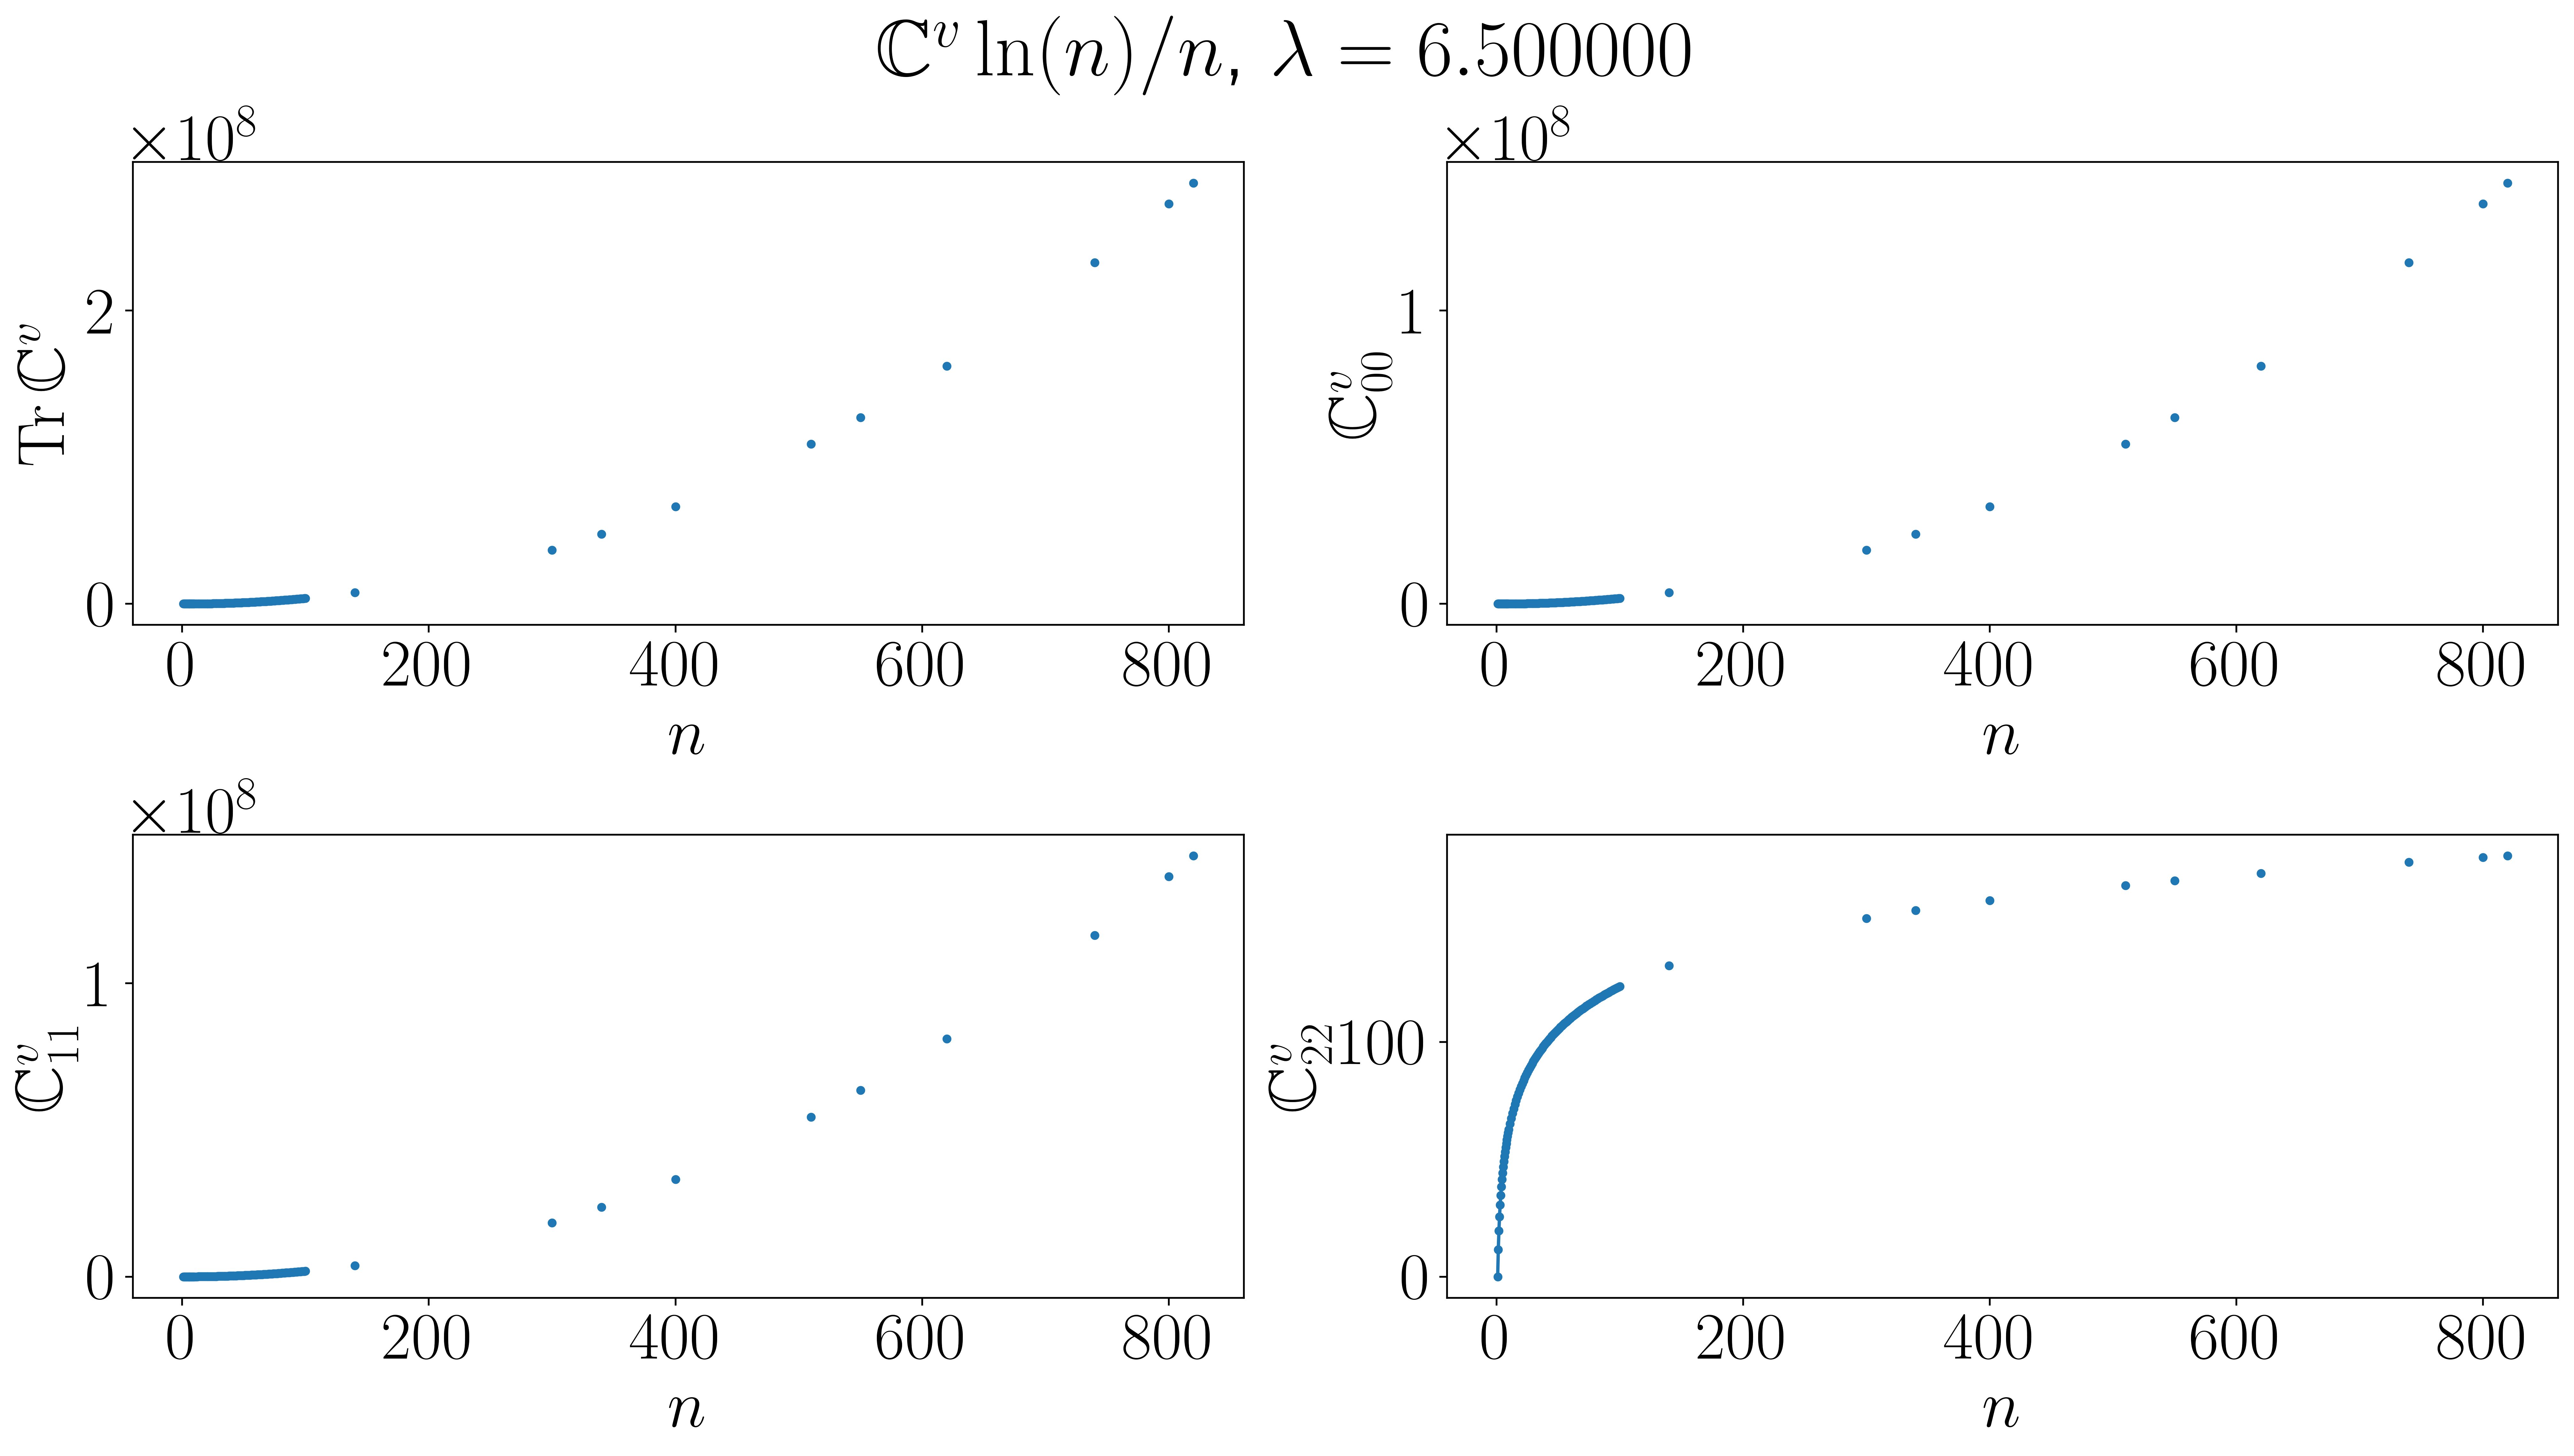

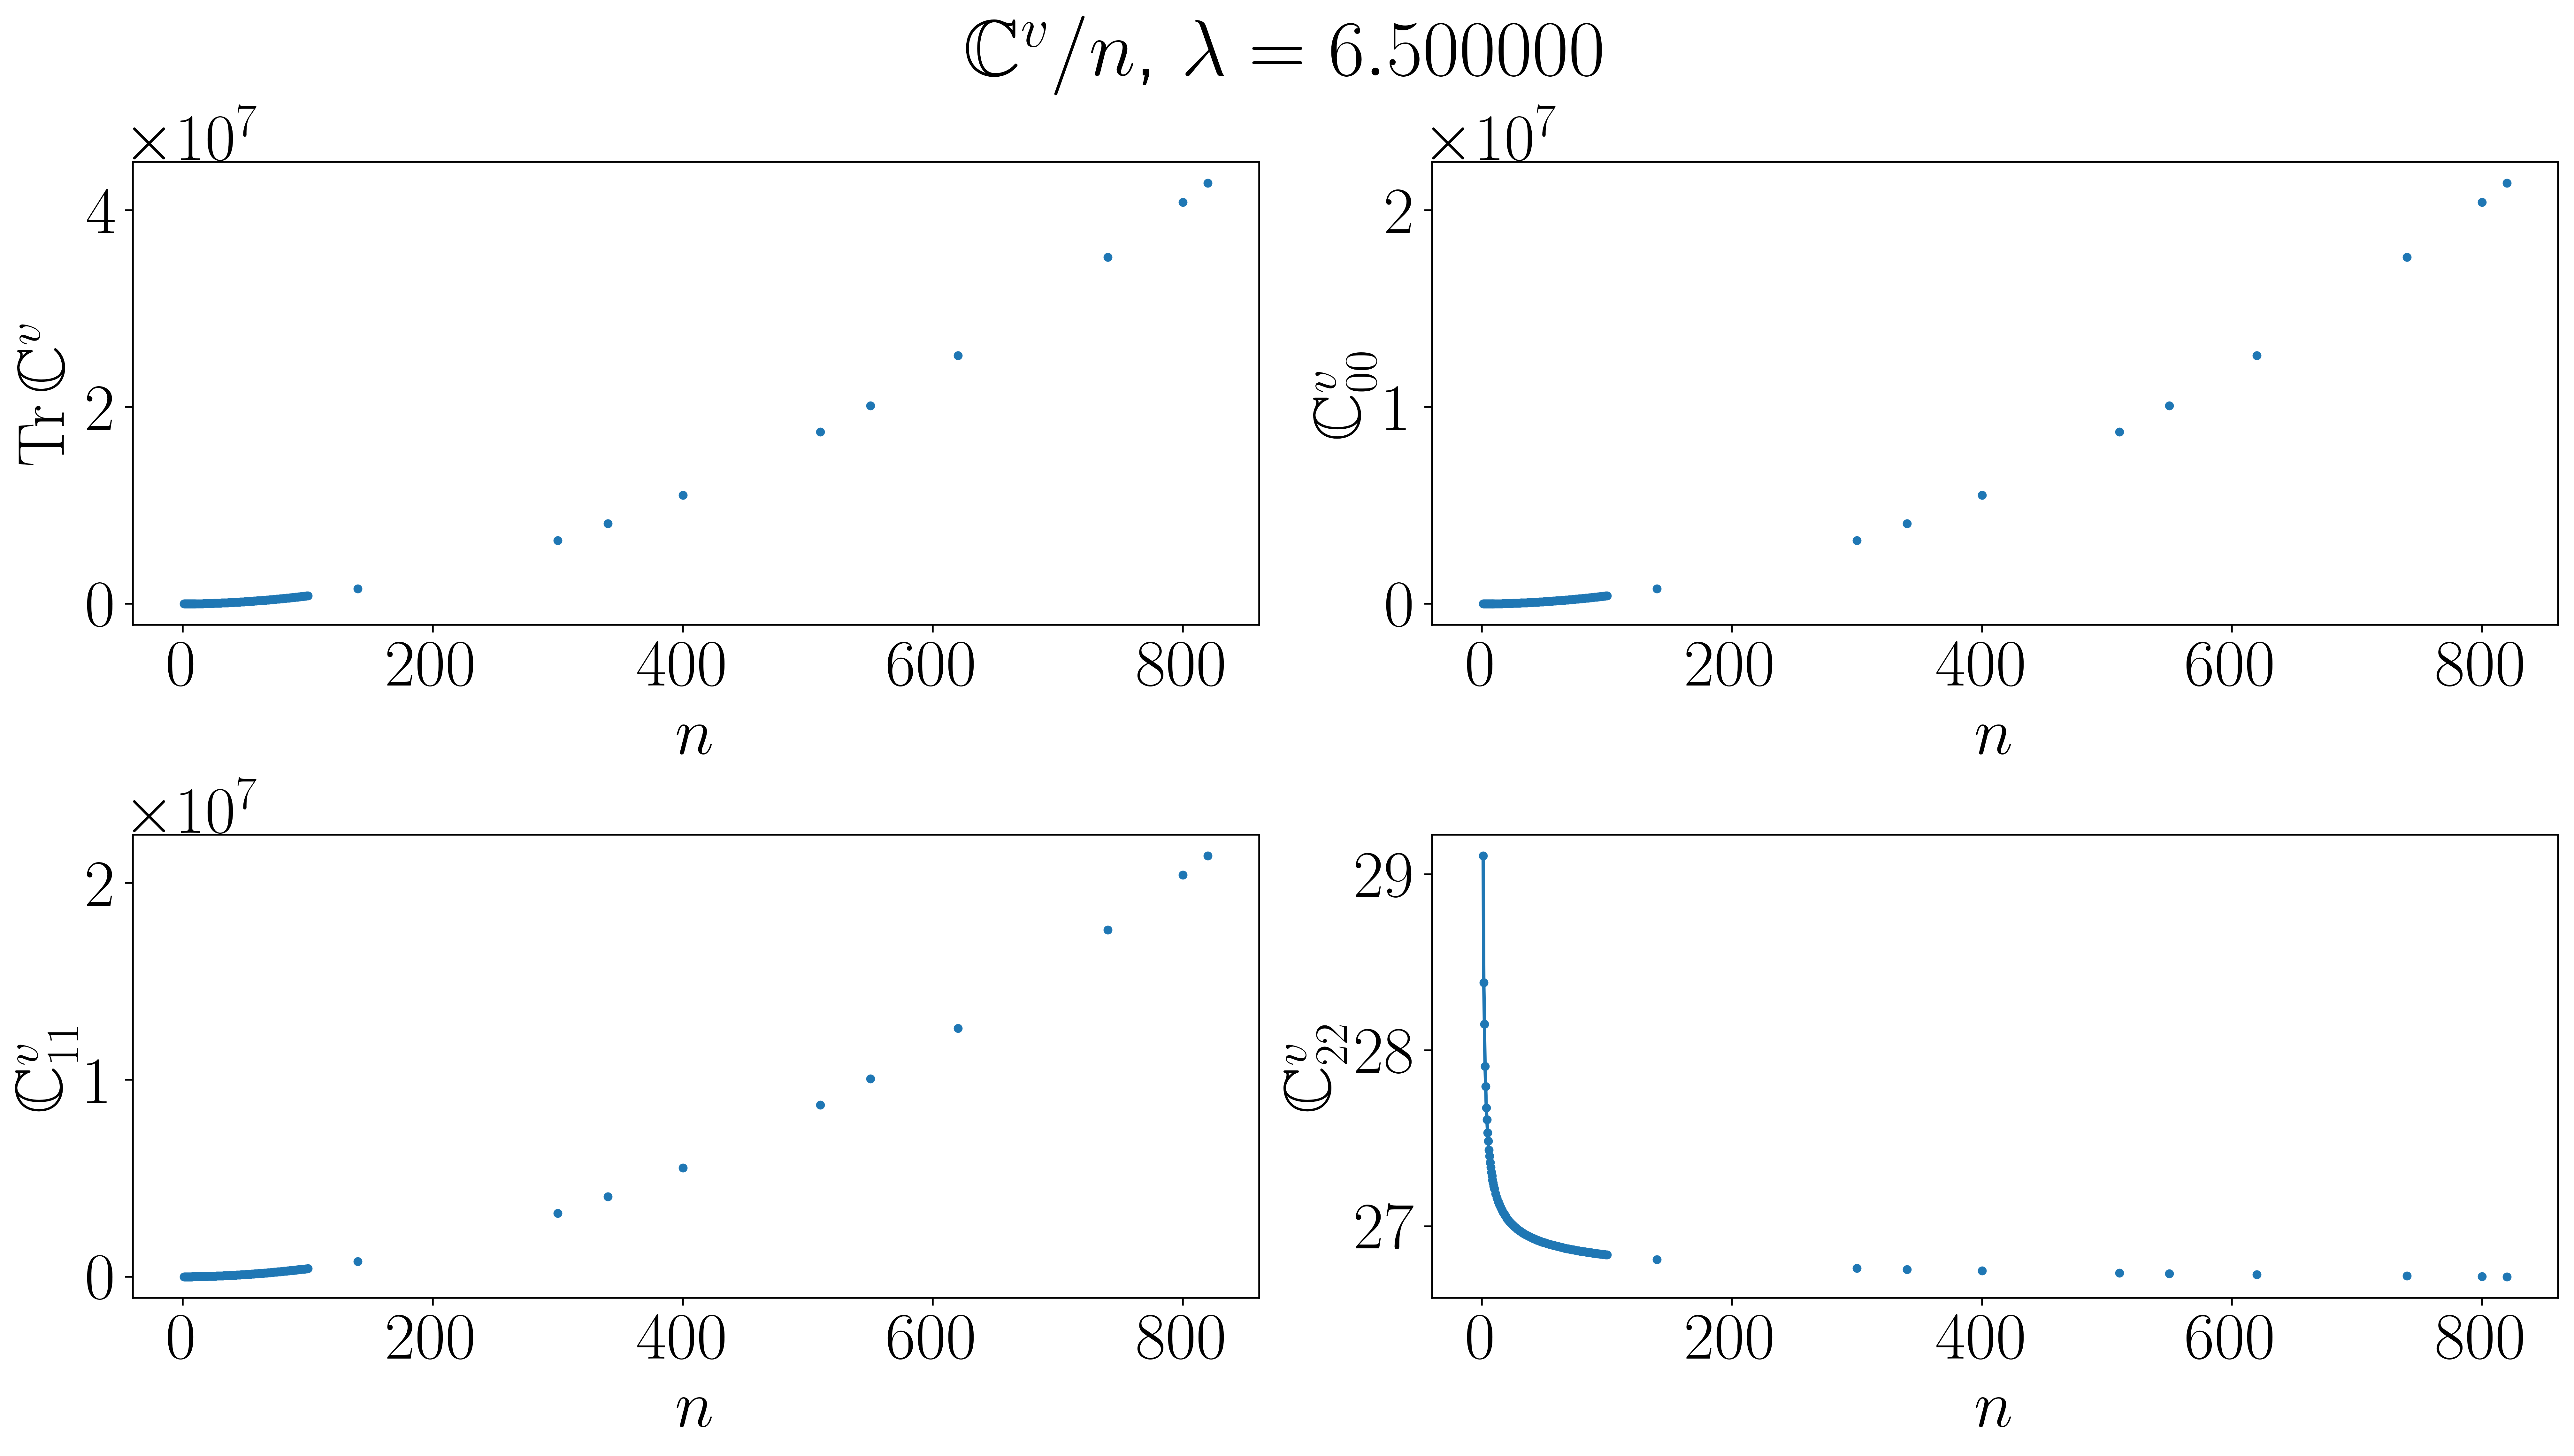

In [7]:
# %matplotlib notebook
%matplotlib inline
def tget_data(t1, ttph):
#     t1 = data_hlx.TrB1
#     ttph = 6.5
    tph = t1.index.values  # ph
    tch = t1.columns.values  # ch
    tt1 = t1.loc[ttph]
    ttvalue = tt1.values
    return tch, ttvalue
    
plt.rcParams.update({'font.size': 30})
figsize=np.array((16, 9)) * 1
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
ttph = 6.5
# ttph = data_hlx.TrC.index.values[-1]

fig, axs = plt.subplots(2, 2, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')
axs = axs.ravel()
#
axi = axs[0]
tch, ttvalue = tget_data(data_hlx.TrC, ttph)
axi.plot(tch, ttvalue * np.log(tch) / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\Tr \\mathbb{C}^v$')
# axi.set_xscale('log')
#
axi = axs[1]
tch, ttvalue = tget_data(data_hlx.C_00, ttph)
axi.plot(tch, ttvalue * np.log(tch) / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{C}^v_{00}$')
# axi.set_xscale('log')
# 
axi = axs[2]
tch, ttvalue = tget_data(data_hlx.C_11, ttph)
axi.plot(tch, ttvalue * np.log(tch) / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{C}^v_{11}$')
# axi.set_xscale('log')
#
axi = axs[3]
tch, ttvalue = tget_data(data_hlx.C_22, ttph)
axi.plot(tch, ttvalue * np.log(tch) / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{C}^v_{22}$')
# axi.set_xscale('log')
fig.suptitle('$\\mathbb{C}^v \\ln(n) / n$, $\\lambda = %f$' % ttph)

#--------------------------------------------------------------------------#
fig, axs = plt.subplots(2, 2, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')
axs = axs.ravel()
#
axi = axs[0]
tch, ttvalue = tget_data(data_hlx.TrC, ttph)
axi.plot(tch, ttvalue / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\Tr \\mathbb{C}^v$')
# axi.set_xscale('log')
#
axi = axs[1]
tch, ttvalue = tget_data(data_hlx.C_00, ttph)
axi.plot(tch, ttvalue / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{C}^v_{00}$')
# axi.set_xscale('log')
# 
axi = axs[2]
tch, ttvalue = tget_data(data_hlx.C_11, ttph)
axi.plot(tch, ttvalue / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{C}^v_{11}$')
# axi.set_xscale('log')
#
axi = axs[3]
tch, ttvalue = tget_data(data_hlx.C_22, ttph)
axi.plot(tch, ttvalue / tch, '.-')
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{C}^v_{22}$')
# axi.set_xscale('log')
fig.suptitle('$\\mathbb{C}^v / n$, $\\lambda = %f$' % ttph)


## Motivation:
Varify $\textbf{A}_{12}$. 

Since the center part of the force distribution along the helix can be approximate well using simple trigonometric functions, $\textbf{A}_{12}$ should only depends on the end parts of the helix, thus the values should convergence for very long helix. 

-1.8585899428153674 1.4799379740500562


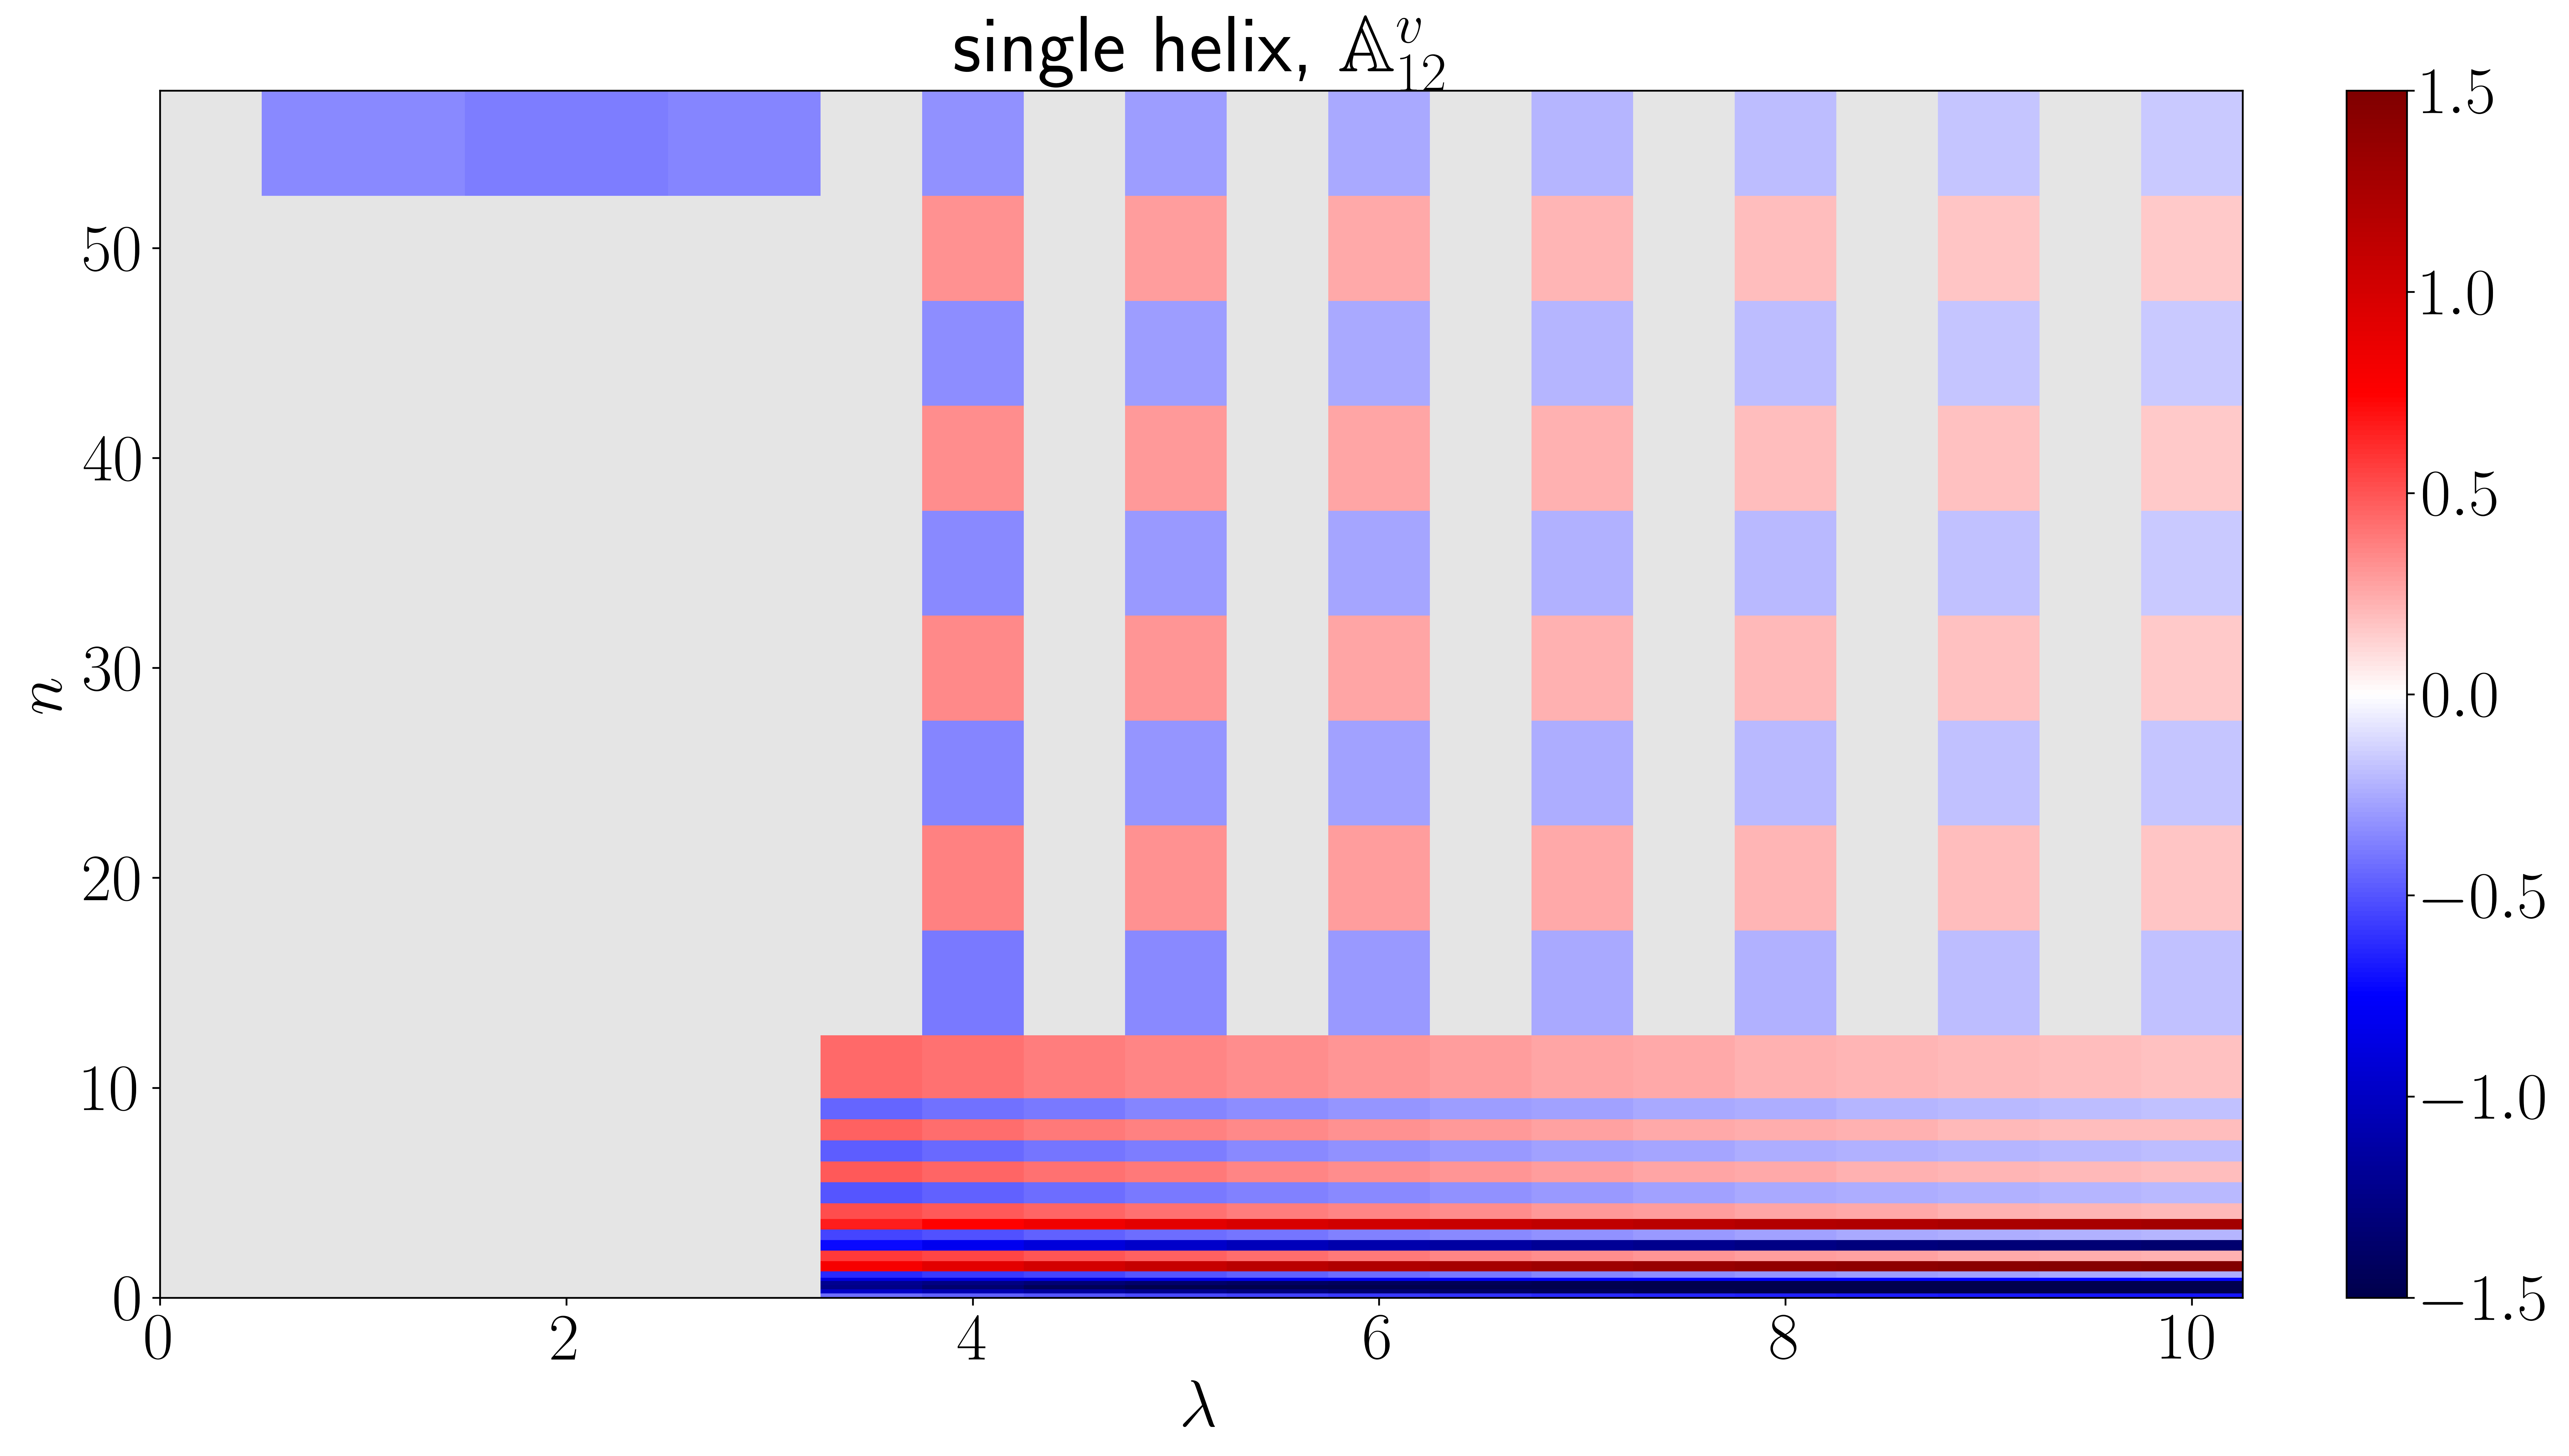

In [38]:
# %matplotlib notebook
%matplotlib inline

plt.rcParams.update({'font.size': 30})
figsize=np.array((16, 9)) * 1
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
#
vmin, vmax, midpoint = -1.5, 1.5, 0
norm = spf.midLinearNorm(midpoint=midpoint, vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('seismic')
# #
# vmin, vmax = None, None
# norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
# cmap = plt.get_cmap('Blues_r')

fig, axs = plt.subplots(1, 1, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')

t1 = data_hlx.A_12
# t1 = data_hlx.TrB2 / data_hlx.TrA
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
tvalue = t1.values.T
axi = axs
im = axi.pcolormesh(tph, tch, tvalue, cmap=cmap, norm=norm, shading='auto')
# cs = axi.contour(tph, tch, tvalue, [0, ], colors='k')
# axi.clabel(cs, inline=True)
fig.colorbar(im, ax=axi, orientation='vertical')
axi.set_xlabel('$\\lambda$')
axi.set_ylabel('$n$')
axi.set_xlim((0, axi.get_xlim()[1]))
axi.set_ylim((0, axi.get_ylim()[1]))
axi.patch.set_facecolor('grey')
axi.patch.set_alpha(0.2)
axi.set_title('single helix, $\\mathbb{A}^v_{12}$')

print(np.nanmin(tvalue), np.nanmax(tvalue))


In [39]:
tph

array([ 1. ,  2. ,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

Text(0, 0.5, '$\\mathbb{A}^v_{12}$')

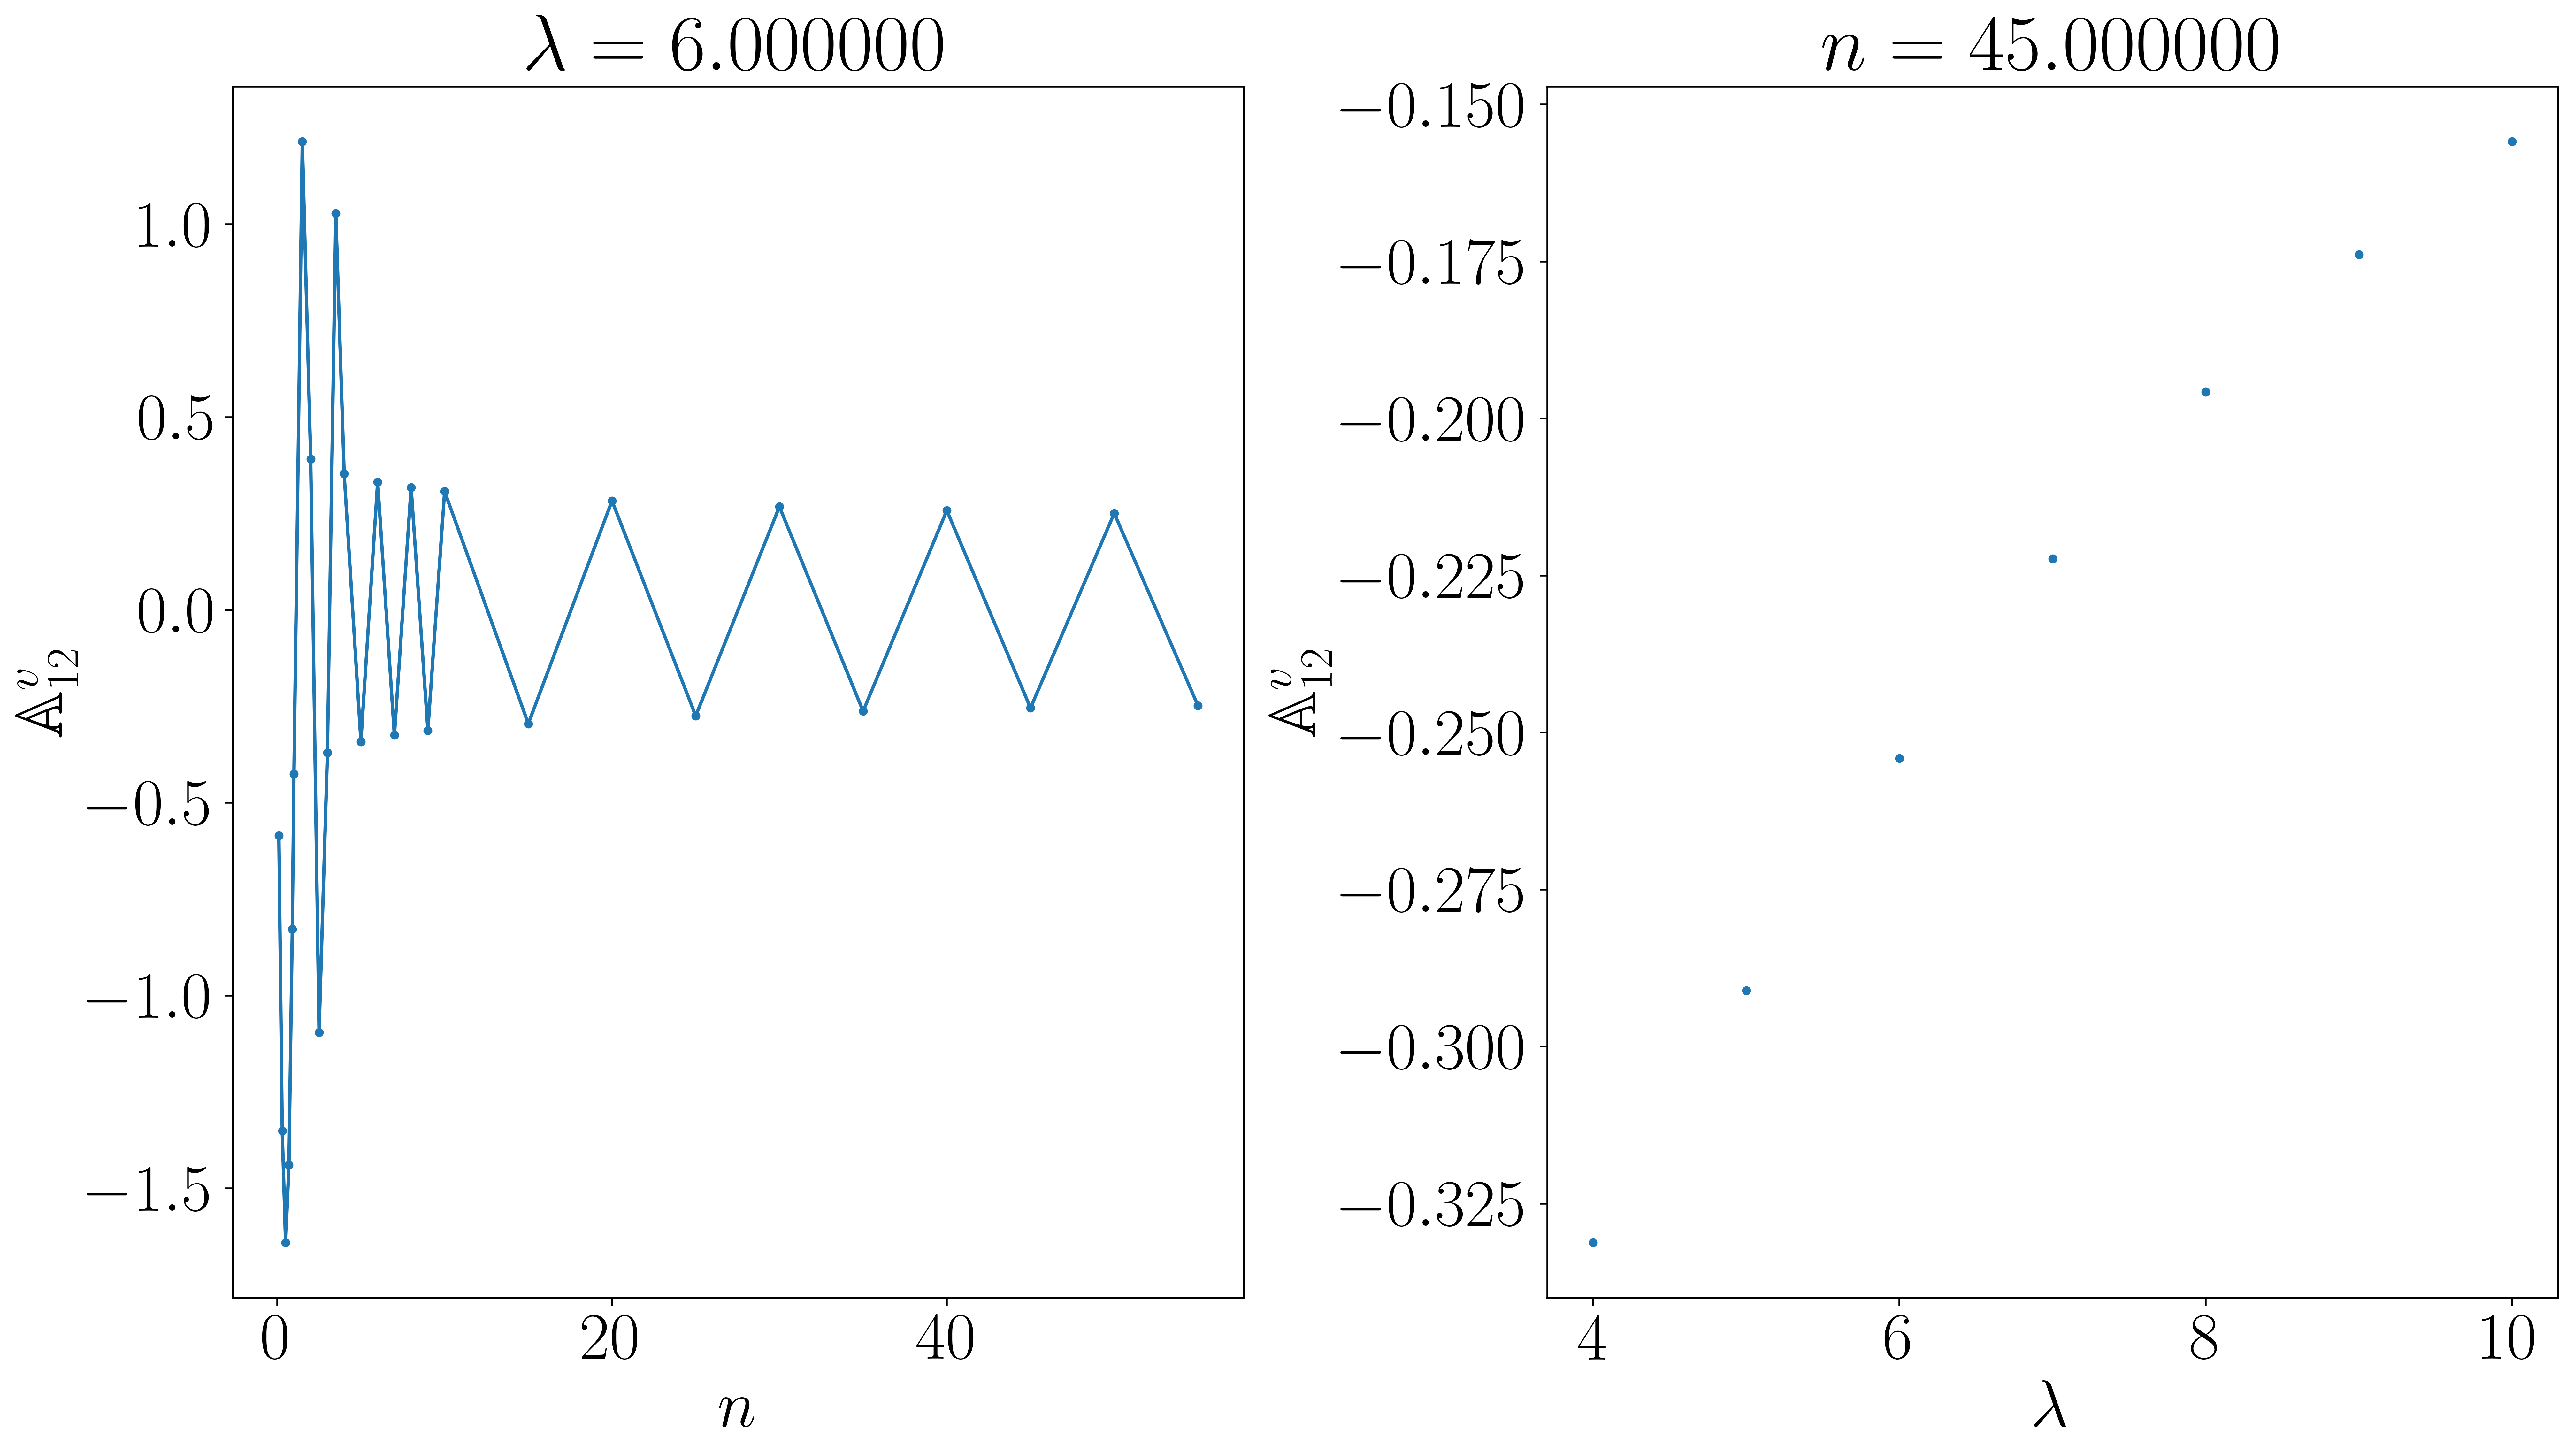

In [42]:
# %matplotlib notebook
%matplotlib inline

plt.rcParams.update({'font.size': 30})
figsize=np.array((16, 9)) * 1
dpi = 500 if 'inline' in matplotlib.get_backend() else 100

t1 = data_hlx.A_12
tph = t1.index.values  # ph
tch = t1.columns.values  # ch

ttph = tph[-9]
ttch = tch[-3]

fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')
#
axi = axs[0]
tt1 = t1.loc[ttph]
ttvalue = tt1.values
axi.plot(tch, ttvalue, '.-')
axi.set_title('$\\lambda = %f$' % ttph)
axi.set_xlabel('$n$')
axi.set_ylabel('$\\mathbb{A}^v_{12}$')
# axi.set_xscale('log')
#
axi = axs[1]
tt1 = t1[ttch]
ttvalue = tt1.values
axi.plot(tph, ttvalue, '.-')
axi.set_title('$n = %f$' % ttch)
axi.set_xlabel('$\\lambda$')
axi.set_ylabel('$\\mathbb{A}^v_{12}$')


In [44]:
data_hlx.A_12.loc[6]

ch
0.1    -0.585584
0.3    -1.350930
0.5    -1.640824
0.7    -1.439226
0.9    -0.828121
1.0    -0.425027
1.5     1.214508
2.0     0.391844
2.5    -1.095186
3.0    -0.369596
3.5     1.028579
4.0     0.353523
5.0    -0.341453
6.0     0.332075
7.0    -0.324394
8.0     0.317934
9.0    -0.312565
10.0    0.307487
15.0   -0.294891
20.0    0.283133
25.0   -0.274599
30.0    0.267891
35.0   -0.262518
40.0    0.258027
45.0   -0.254106
50.0    0.250777
55.0   -0.247809
Name: 6.0, dtype: float64

## Motivation:
Same as previous section, varify $\textbf{B}_{00}$. 

Since the center part of the force distribution along the helix can be approximate well using simple trigonometric functions, one has 

$\textbf{B}_{00} + \textbf{B}_{11} = \textbf{B}^e_{11}$, 

here $\textbf{B}^e_{11}$ is the contribution of the end parts of the helix, and  the values should convergence for very long helix. 

-2.8626987829035633 9.15686516819964


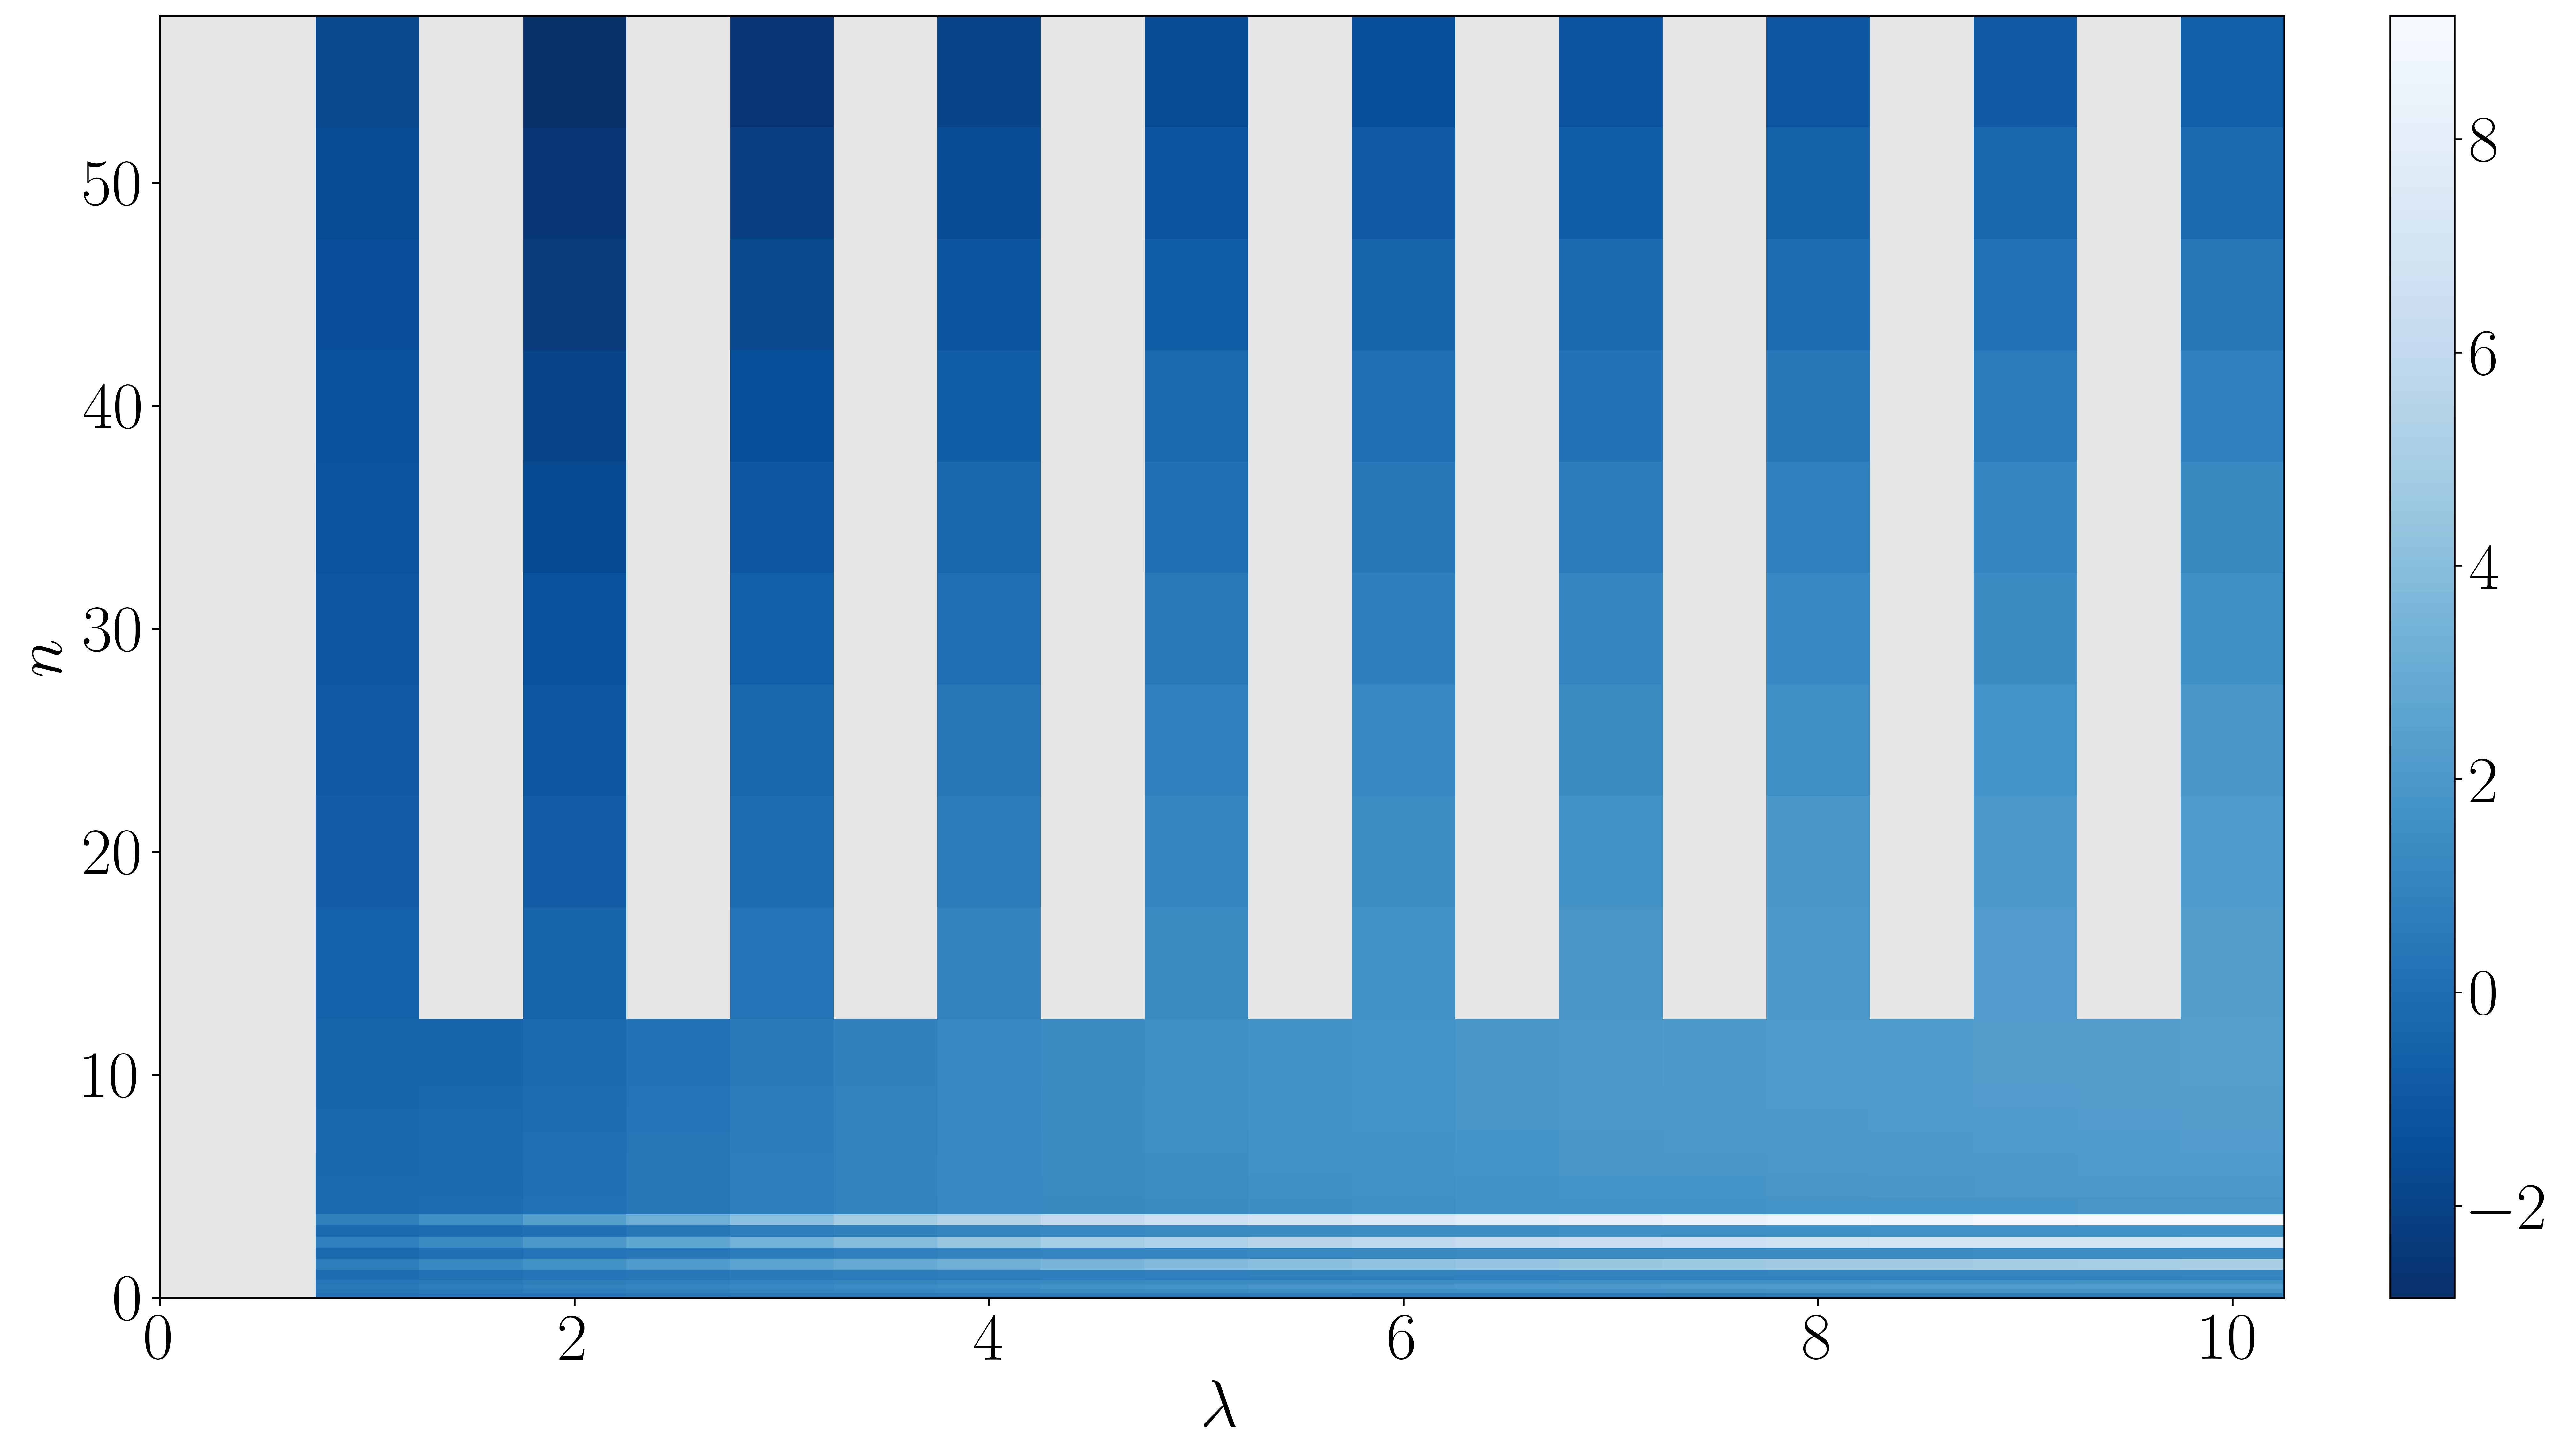

In [75]:
# %matplotlib notebook
%matplotlib inline

plt.rcParams.update({'font.size': 30})
figsize=np.array((16, 9)) * 1
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
# #
# vmin, vmax, midpoint = -1.5, 1.5, 0
# norm = spf.midLinearNorm(midpoint=midpoint, vmin=vmin, vmax=vmax)
# cmap = plt.get_cmap('seismic')
#
vmin, vmax = None, None
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('Blues_r')

fig, axs = plt.subplots(1, 1, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')

t1 = data_hlx.B1_11
tph = t1.index.values  # ph
tch = t1.columns.values  # ch
tvalue = t1.values.T
axi = axs
im = axi.pcolormesh(tph, tch, tvalue, cmap=cmap, norm=norm, shading='auto')
# cs = axi.contour(tph, tch, tvalue, [0, ], colors='k')
# axi.clabel(cs, inline=True)
fig.colorbar(im, ax=axi, orientation='vertical')
axi.set_xlabel('$\\lambda$')
axi.set_ylabel('$n$')
axi.set_xlim((0, axi.get_xlim()[1]))
axi.set_ylim((0, axi.get_ylim()[1]))
axi.patch.set_facecolor('grey')
axi.patch.set_alpha(0.2)
# axi.set_title('single helix, $\\mathbb{B}^{v1}_{00}$')

print(np.nanmin(tvalue), np.nanmax(tvalue))


In [79]:
data_hlx.B1_11.loc[6]

ch
0.1     0.596732
0.3     1.524607
0.5     1.924759
0.7     1.453504
0.9     0.826965
1.0     0.904479
1.5     4.190684
2.0     1.226722
2.5     5.909747
3.0     1.423017
3.5     7.429756
4.0     1.544387
5.0     1.633708
6.0     1.695617
7.0     1.738247
8.0     1.765601
9.0     1.780848
10.0    1.783485
15.0    1.649674
20.0    1.429806
25.0    1.141080
30.0    0.782227
35.0    0.419191
40.0    0.009296
45.0   -0.465206
50.0   -0.890048
55.0   -1.367233
Name: 6.0, dtype: float64